## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration and Distortion correction

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

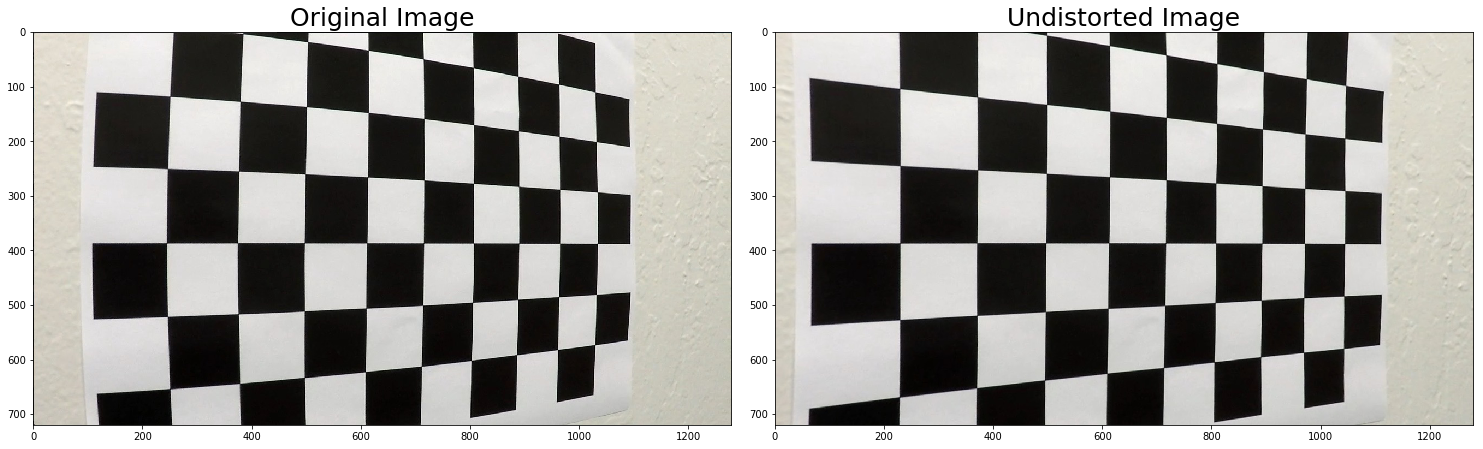

In [3]:
#test undistort_image function
img_org = mpimg.imread('./camera_cal/calibration5.jpg')
img_undistorted = undistort_image(img_org,objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img_org)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/undistort_output.jpg')

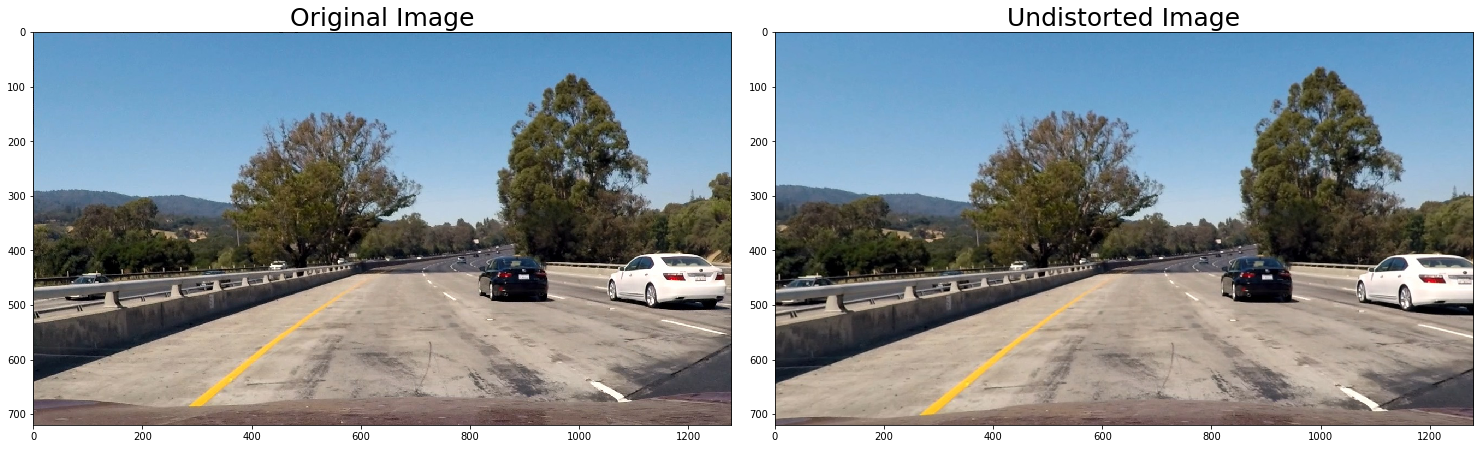

In [4]:
#test undistort_image function
img_org = mpimg.imread('./test_images/test1.jpg')
img_undistorted = undistort_image(img_org,objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img_org)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/undistort_output2.jpg')

## Color/gradient Threshold


In [5]:
# Retuns binary image based on thresholding functions
# def pipeline(img,sobel_kernel=3,sx_thresh=(20,100), s_thresh=(180,255)):
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     s_channel = hls[:,:,2]
 
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
#     abs_sobelx = np.absolute(sobelx) 
#     scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
 
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

#     s_binary = np.zeros_like(s_channel)
#     s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
 
#         # Combine the two binary thresholds
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
#     return combined_binary
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

def pipeline(image):
    yellow = select_yellow(image)
    white = select_white(image)
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    return combined_binary

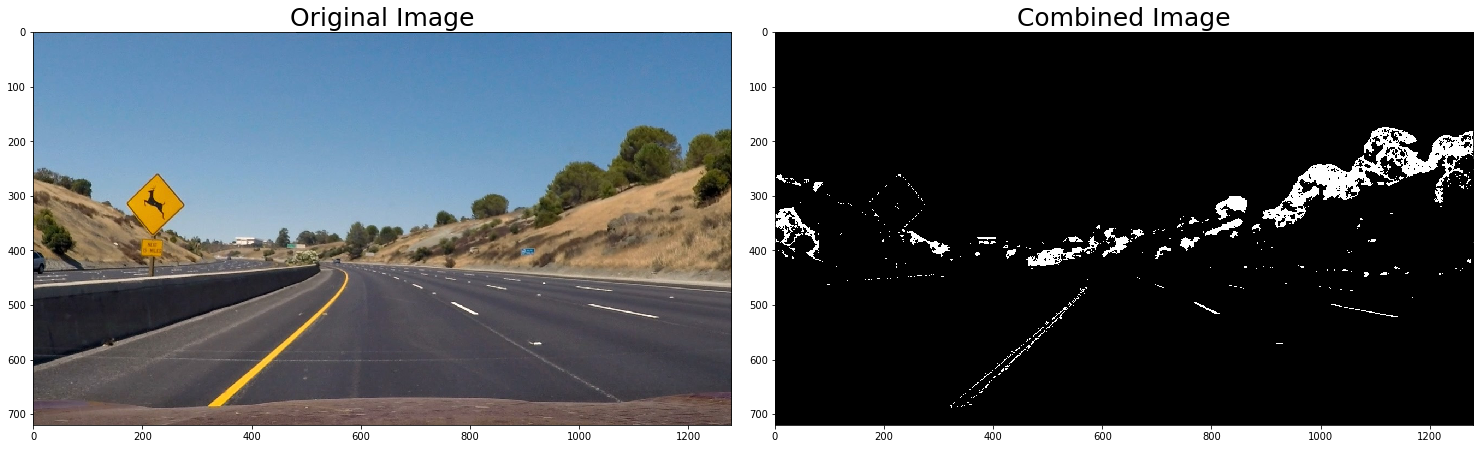

In [6]:
# Read in an image
test_image = mpimg.imread('./test_images/test2.jpg')

# Obtain binary image
combined = pipeline(test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/binary_combo_example.jpg')

## Perspective Transformation

In [7]:
img_size = (img.shape[1], img.shape[0])
#src = np.float32([[585, 460],[695, 460],[1126, 720],[203, 720]])
#dst = np.float32([[275, 0],[1025,0], [960, 720], [320, 720]])
src = np.float32([[545, 460], [735, 460],  [1280, 700], [0, 700]])
dst = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

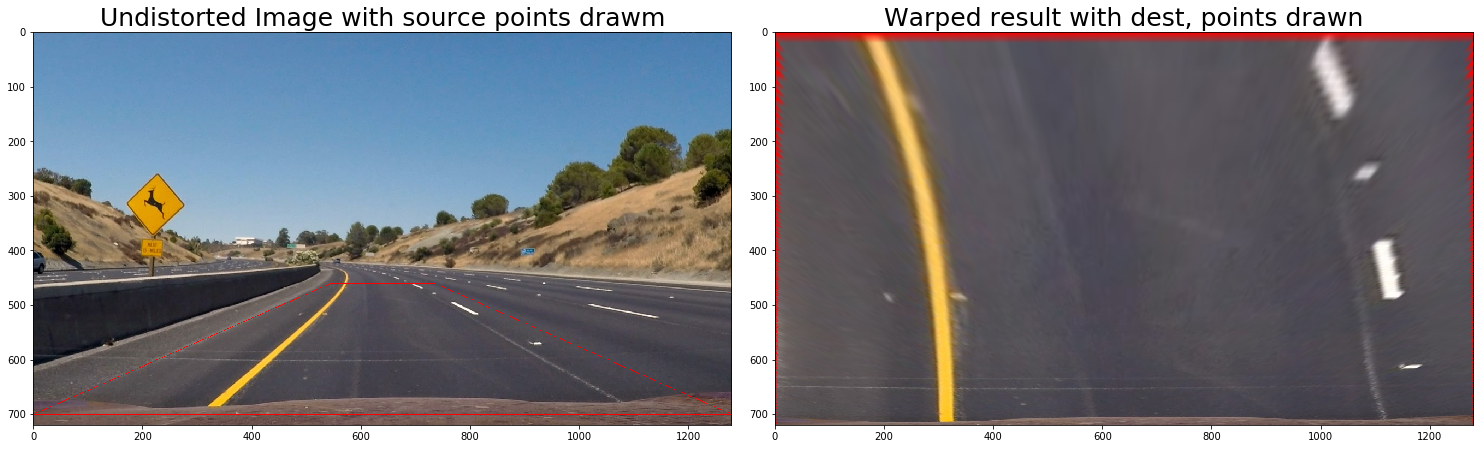

In [8]:
def make_plot(img, points, color=[255,0,0], thickness=1):
#    image = np.copy(img)
    cv2.line(img, (points[0][0], points[0][1]), (points[1][0], points[1][1]), color, thickness)
    cv2.line(img, (points[1][0], points[1][1]), (points[2][0], points[2][1]), color, thickness)
    cv2.line(img, (points[2][0], points[2][1]), (points[3][0], points[3][1]), color, thickness)
    cv2.line(img, (points[3][0], points[3][1]), (points[0][0], points[0][1]), color, thickness)
    return img

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Undistorted Image with source points drawm',fontsize=25)
ax1.imshow(make_plot(test_image, src))
ax2.set_title('Warped result with dest, points drawn',fontsize=25)
warped_img, M, Minv = warp(test_image,src,dst)
ax2.imshow(make_plot(warped_img, dst))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)   
plt.show()
f.savefig('output_images/warped_straight_lines.jpg')

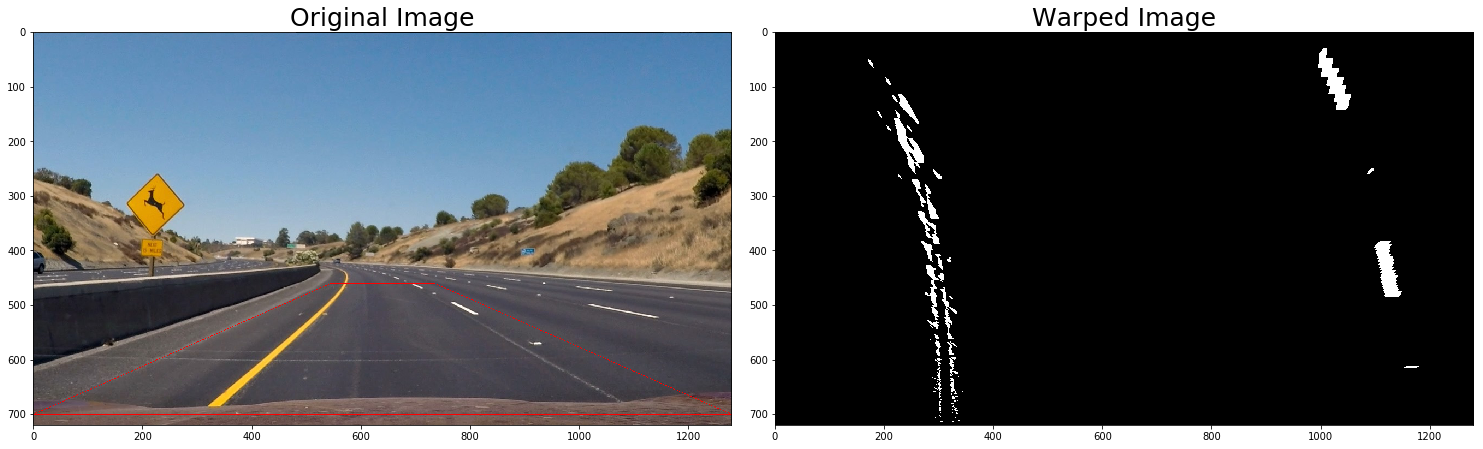

In [9]:
# Obtain binary image
warped_img, M, Minv = warp(combined, src, dst)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

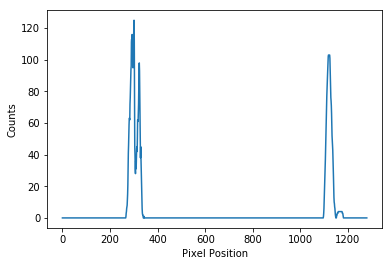

In [10]:
# Histogram Plotting
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlabel('Pixel Position')
plt.ylabel('Counts')
plt.show()

## Find the Lines


In [11]:

# Take a histogram of the bottom half of the image
#
# Create an output image to draw on and  visualize the result
def sliding_fit(img, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []

# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

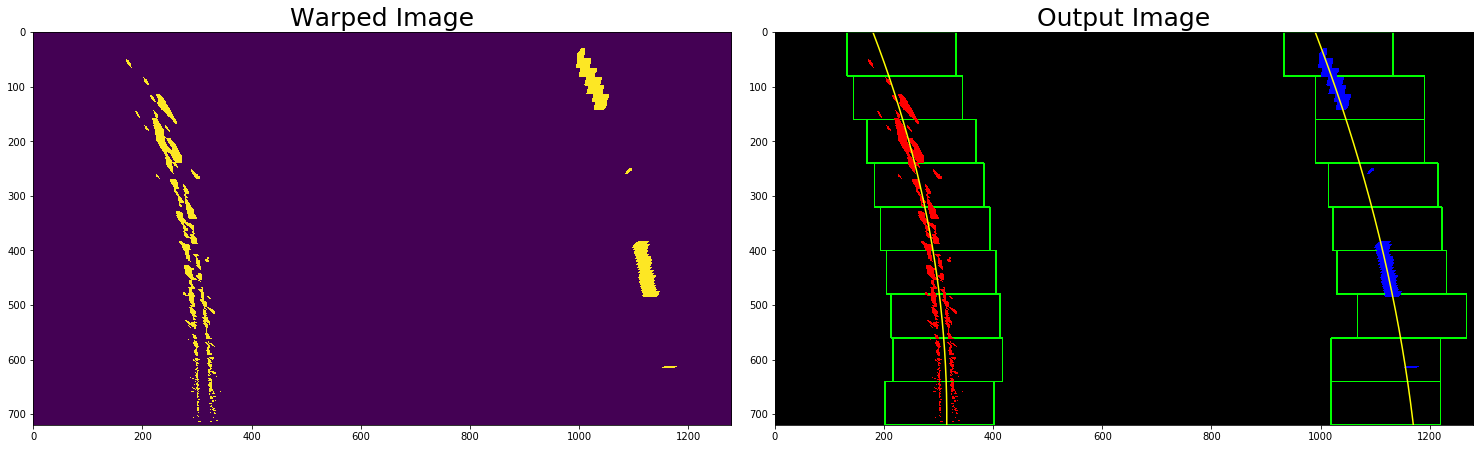

In [12]:
#Visualization
out_img = np.dstack((warped_img, warped_img, warped_img))*255
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_fit(warped_img)
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rectangle in rectangles: 
    cv2.rectangle(out_img, (rectangle[5], rectangle[1]), (rectangle[4], rectangle[0]), (0,255,0), 2) 
    cv2.rectangle(out_img, (rectangle[3], rectangle[1]), (rectangle[2], rectangle[0]), (0,255,0), 2) 
    
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/color_fit_lines.jpg')


In [13]:
def further_fit(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


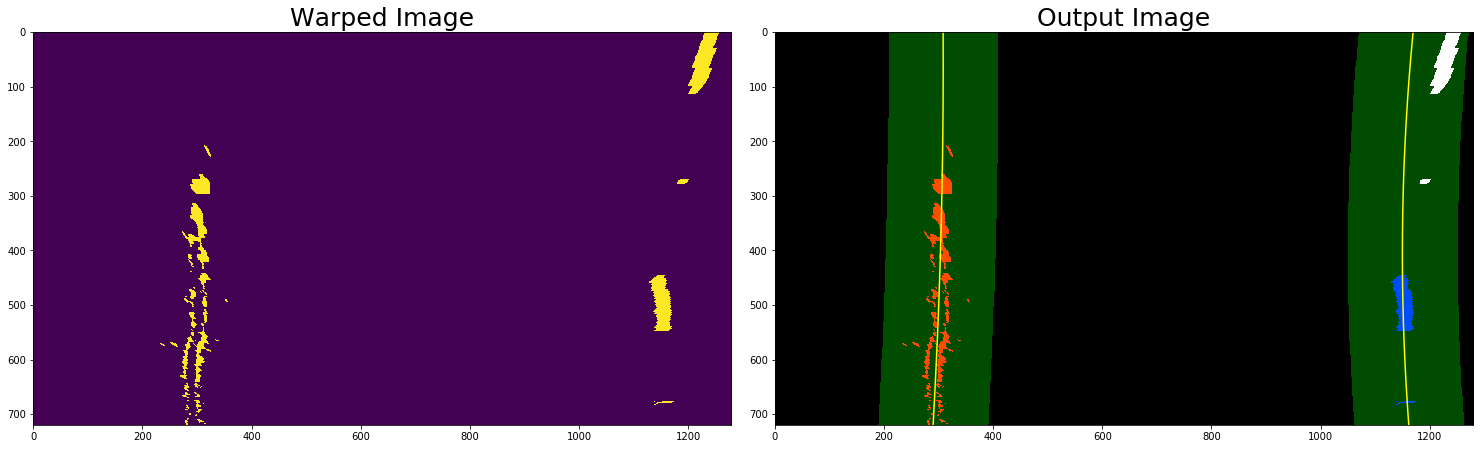

In [14]:
# Visulalization
test_image_new = mpimg.imread('./test_images/test4.jpg')
test_image_new = undistort_image(test_image_new,objpoints, imgpoints)
combined_new = pipeline(test_image_new)
warped_img_new, _, Minv = warp(combined_new, src, dst)

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = further_fit(warped_img_new, left_fit, right_fit)
ploty = np.linspace(0, warped_img_new.shape[0]-1, warped_img_new.shape[0] )
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_img_new, warped_img_new, warped_img_new))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = warped_img_new.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img_new)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Measure Curvature and Offset

In [15]:
def compute_curvature_offset(img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    lane_center = np.mean([left_fitx[-1], right_fitx[-1]])
    offset = ((img.shape[1] / 2) - lane_center) * xm_per_pix
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', offset, 'm')
    return left_curverad, right_curverad, offset

In [16]:
def add_measurements(img, left_curverad, right_curverad, offset):
    # add curverature to image
    text = "Radius of Curvature= {:.2f}(m)".format(int((left_curverad + right_curverad)/2))
    cv2.putText(img, text, (50,50), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    
    # add lane offset to image
    if offset > 0:
        text = "Vehicle is {:.2f}m right of center".format(offset)
    elif offset < 0:
        text = "Vehicle is {:.2f}m left of center".format(offset)
    cv2.putText(img, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    return img

## Draw Lines

In [17]:
def draw(img, warped_img, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])

       
    left_fitx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [18]:
def process_image(img):
    img_undistorted = undistort_image(img,objpoints, imgpoints)
    combined_img = pipeline(img_undistorted)
    warped_img, M, Minv = warp(combined_img, src, dst)
    
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_fit(warped_img)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = further_fit(warped_img, left_line.best_fit, right_line.best_fit)

    left_line.lane_fit(left_fit)
    right_line.lane_fit(right_fit)
    
    img = draw(img_undistorted, combined_img, left_line.best_fit, right_line.best_fit, Minv)
    left_curverad, right_curverad, offset = compute_curvature_offset(img, left_fit, right_fit)
    final_img =add_measurements(img, left_curverad, right_curverad, offset)

    return final_img

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def lane_fit(self, fit):
        if self.best_fit is not None:
            self.diffs = abs(fit-self.best_fit)
        if (self.diffs[0] > 0.01 or self.diffs[1] > 1.0 or self.diffs[2] > 100.0) and len(self.current_fit) > 0:
            self.detected = False
        else:
            self.detected = True
            
            self.current_fit.append(fit)

            if len(self.current_fit) > 5:
                self.current_fit = self.current_fit[len(self.current_fit)- 5:]
            self.best_fit = np.average(self.current_fit, axis=0)
      

447.184497199 m 1110.31373533 m -0.314408432962 m


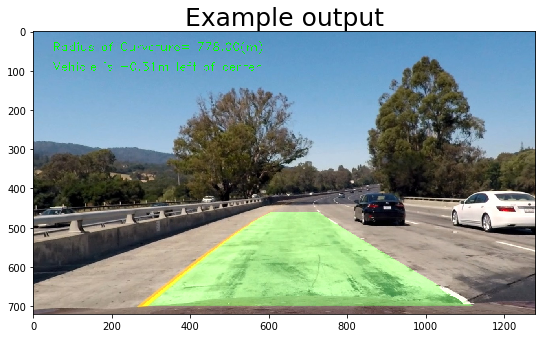

In [20]:
test_image = mpimg.imread('./test_images/test1.jpg')
left_line = Line()
right_line = Line()
new_img = process_image(test_image)
f, ax = plt.subplots(figsize=(9, 6))
ax.imshow(new_img)
ax.set_title('Example output',fontsize=25)
plt.show()
f.savefig('output_images/example_output.jpg')

## Video Test

In [21]:

left_line = Line()
right_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
processed_video.write_videofile(video_output, audio=False)

507.774054335 m 621.986084205 m -0.468478342979 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

507.774054335 m 621.986084205 m -0.468478342979 m


  0%|                                                                                 | 1/1261 [00:00<13:45,  1.53it/s]

550.60044958 m 767.811309341 m -0.490575404942 m


  0%|▏                                                                                | 2/1261 [00:01<13:51,  1.51it/s]

586.741813534 m 672.073655037 m -0.497043963213 m


  0%|▏                                                                                | 3/1261 [00:01<13:52,  1.51it/s]

721.555454052 m 613.994324378 m -0.50522785678 m


  0%|▎                                                                                | 4/1261 [00:02<13:45,  1.52it/s]

671.206487413 m 620.172908755 m -0.501747830688 m


  0%|▎                                                                                | 5/1261 [00:03<13:44,  1.52it/s]

502.58597459 m 664.782986553 m -0.493288522405 m


  0%|▍                                                                                | 6/1261 [00:03<13:42,  1.53it/s]

464.841909209 m 671.583876829 m -0.487861809078 m


  1%|▍                                                                                | 7/1261 [00:04<13:51,  1.51it/s]

447.996906079 m 1183.59898286 m -0.537692188419 m


  1%|▌                                                                                | 8/1261 [00:05<13:50,  1.51it/s]

465.353777457 m 1167.51630628 m -0.523745419039 m


  1%|▌                                                                                | 9/1261 [00:05<13:54,  1.50it/s]

611.940773137 m 1181.2092246 m -0.550116223288 m


  1%|▋                                                                               | 10/1261 [00:06<13:52,  1.50it/s]

794.588413732 m 1115.12259147 m -0.56516771488 m


  1%|▋                                                                               | 11/1261 [00:07<14:04,  1.48it/s]

646.18550106 m 1265.70780336 m -0.540064263855 m


  1%|▊                                                                               | 12/1261 [00:08<14:16,  1.46it/s]

572.522258497 m 1190.5284822 m -0.542482746155 m


  1%|▊                                                                               | 13/1261 [00:08<14:13,  1.46it/s]

770.495516902 m 907.414243491 m -0.544164506788 m


  1%|▉                                                                               | 14/1261 [00:09<14:07,  1.47it/s]

1040.93765255 m 1298.24810933 m -0.537891773032 m


  1%|▉                                                                               | 15/1261 [00:10<14:02,  1.48it/s]

656.379489007 m 794.777638506 m -0.505413824218 m


  1%|█                                                                               | 16/1261 [00:10<14:08,  1.47it/s]

702.840965474 m 832.336262416 m -0.497953481499 m


  1%|█                                                                               | 17/1261 [00:11<13:53,  1.49it/s]

795.780947475 m 837.848003304 m -0.482633586741 m


  1%|█▏                                                                              | 18/1261 [00:12<13:51,  1.50it/s]

998.873633026 m 883.822104517 m -0.485711822723 m


  2%|█▏                                                                              | 19/1261 [00:12<13:46,  1.50it/s]

783.848321397 m 904.76798077 m -0.470418687424 m


  2%|█▎                                                                              | 20/1261 [00:13<13:52,  1.49it/s]

687.783293746 m 934.92005589 m -0.453518564452 m


  2%|█▎                                                                              | 21/1261 [00:14<13:52,  1.49it/s]

787.969120751 m 925.69361977 m -0.450597723759 m


  2%|█▍                                                                              | 22/1261 [00:14<14:01,  1.47it/s]

740.094140588 m 1016.15144787 m -0.452359232104 m


  2%|█▍                                                                              | 23/1261 [00:15<14:10,  1.46it/s]

1528.81856588 m 951.94099919 m -0.474329634793 m


  2%|█▌                                                                              | 24/1261 [00:16<14:16,  1.44it/s]

1571.31922357 m 828.317428835 m -0.457630682362 m


  2%|█▌                                                                              | 25/1261 [00:16<14:22,  1.43it/s]

1239.39946808 m 710.758792312 m -0.435856158156 m


  2%|█▋                                                                              | 26/1261 [00:17<14:22,  1.43it/s]

846.294997256 m 744.78050035 m -0.428442870831 m


  2%|█▋                                                                              | 27/1261 [00:18<14:07,  1.46it/s]

768.48049538 m 721.597096292 m -0.417792026778 m


  2%|█▊                                                                              | 28/1261 [00:18<14:05,  1.46it/s]

645.329241062 m 601.012430507 m -0.410123980585 m


  2%|█▊                                                                              | 29/1261 [00:19<14:07,  1.45it/s]

457.715992788 m 618.611098249 m -0.388964817962 m


  2%|█▉                                                                              | 30/1261 [00:20<14:10,  1.45it/s]

490.200566805 m 610.763319261 m -0.389049298038 m


  2%|█▉                                                                              | 31/1261 [00:21<14:13,  1.44it/s]

431.073722409 m 609.909174551 m -0.394686307816 m


  3%|██                                                                              | 32/1261 [00:21<14:06,  1.45it/s]

449.239954667 m 707.801599688 m -0.411998117079 m


  3%|██                                                                              | 33/1261 [00:22<13:59,  1.46it/s]

429.012805835 m 828.05562396 m -0.43669189153 m


  3%|██▏                                                                             | 34/1261 [00:23<14:02,  1.46it/s]

478.166206332 m 883.080638032 m -0.437410939199 m


  3%|██▏                                                                             | 35/1261 [00:23<14:22,  1.42it/s]

431.272117418 m 886.187171233 m -0.461588253086 m


  3%|██▎                                                                             | 36/1261 [00:24<15:04,  1.35it/s]

457.648086509 m 683.459202012 m -0.431181308521 m


  3%|██▎                                                                             | 37/1261 [00:25<15:32,  1.31it/s]

397.342911525 m 621.376536408 m -0.421455934705 m


  3%|██▍                                                                             | 38/1261 [00:26<15:13,  1.34it/s]

364.255453407 m 747.062446778 m -0.432450029516 m


  3%|██▍                                                                             | 39/1261 [00:26<14:59,  1.36it/s]

402.899704249 m 496.871998285 m -0.414523040367 m


  3%|██▌                                                                             | 40/1261 [00:27<14:44,  1.38it/s]

428.626206922 m 494.531011785 m -0.427354567079 m


  3%|██▌                                                                             | 41/1261 [00:28<14:20,  1.42it/s]

417.461034653 m 535.859620942 m -0.431913696497 m


  3%|██▋                                                                             | 42/1261 [00:28<14:01,  1.45it/s]

454.863163222 m 533.711031136 m -0.44022353702 m


  3%|██▋                                                                             | 43/1261 [00:29<14:07,  1.44it/s]

418.444510145 m 556.037881645 m -0.430982839213 m


  3%|██▊                                                                             | 44/1261 [00:30<14:01,  1.45it/s]

450.86258287 m 574.858301712 m -0.449313309383 m


  4%|██▊                                                                             | 45/1261 [00:30<14:10,  1.43it/s]

489.756832289 m 793.121184507 m -0.488771410799 m


  4%|██▉                                                                             | 46/1261 [00:31<14:12,  1.43it/s]

485.475897366 m 702.263004341 m -0.481301589243 m


  4%|██▉                                                                             | 47/1261 [00:32<14:22,  1.41it/s]

532.211693484 m 703.8645868 m -0.473068420699 m


  4%|███                                                                             | 48/1261 [00:33<14:35,  1.39it/s]

685.371601075 m 791.574073915 m -0.501840228709 m


  4%|███                                                                             | 49/1261 [00:33<14:27,  1.40it/s]

743.306561427 m 707.643814317 m -0.503914101333 m


  4%|███▏                                                                            | 50/1261 [00:34<14:22,  1.40it/s]

780.401083279 m 633.129033251 m -0.496158606682 m


  4%|███▏                                                                            | 51/1261 [00:35<14:18,  1.41it/s]

779.510034706 m 652.666539376 m -0.494614989658 m


  4%|███▎                                                                            | 52/1261 [00:36<14:22,  1.40it/s]

956.374904591 m 519.927481836 m -0.478162023212 m


  4%|███▎                                                                            | 53/1261 [00:36<14:16,  1.41it/s]

1353.1227 m 528.260892324 m -0.481384159788 m


  4%|███▍                                                                            | 54/1261 [00:37<14:06,  1.43it/s]

1354.40446931 m 522.349927368 m -0.468424485458 m


  4%|███▍                                                                            | 55/1261 [00:38<13:50,  1.45it/s]

1112.16548808 m 572.890750202 m -0.460741189523 m


  4%|███▌                                                                            | 56/1261 [00:38<13:45,  1.46it/s]

825.420592401 m 596.972107915 m -0.446288879289 m


  5%|███▌                                                                            | 57/1261 [00:39<13:34,  1.48it/s]

804.11231476 m 638.751602675 m -0.437729301998 m


  5%|███▋                                                                            | 58/1261 [00:40<13:26,  1.49it/s]

663.929173209 m 778.465757264 m -0.452574843852 m


  5%|███▋                                                                            | 59/1261 [00:40<13:24,  1.49it/s]

711.276450195 m 876.865646837 m -0.449243832827 m


  5%|███▊                                                                            | 60/1261 [00:41<13:18,  1.50it/s]

785.711678554 m 809.435394342 m -0.446241441494 m


  5%|███▊                                                                            | 61/1261 [00:42<13:22,  1.49it/s]

840.108799802 m 769.265752913 m -0.440229212837 m


  5%|███▉                                                                            | 62/1261 [00:42<13:33,  1.47it/s]

715.360568123 m 699.442237288 m -0.408890050336 m


  5%|███▉                                                                            | 63/1261 [00:43<13:36,  1.47it/s]

680.116129229 m 615.565929805 m -0.391816492087 m


  5%|████                                                                            | 64/1261 [00:44<13:40,  1.46it/s]

665.343133602 m 735.982462237 m -0.38427819418 m


  5%|████                                                                            | 65/1261 [00:44<13:39,  1.46it/s]

632.388508443 m 788.640242495 m -0.368794603691 m


  5%|████▏                                                                           | 66/1261 [00:45<13:46,  1.45it/s]

672.734977101 m 786.885152148 m -0.357563203496 m


  5%|████▎                                                                           | 67/1261 [00:46<13:40,  1.46it/s]

612.641042466 m 820.145556108 m -0.33760088545 m


  5%|████▎                                                                           | 68/1261 [00:46<13:30,  1.47it/s]

491.061113967 m 802.885581148 m -0.337757603546 m


  5%|████▍                                                                           | 69/1261 [00:47<13:22,  1.49it/s]

414.49224873 m 886.525197722 m -0.327629094944 m


  6%|████▍                                                                           | 70/1261 [00:48<13:21,  1.49it/s]

439.881378978 m 1644.5506928 m -0.359770821726 m


  6%|████▌                                                                           | 71/1261 [00:48<13:30,  1.47it/s]

539.080941052 m 1443.62943846 m -0.34796348321 m


  6%|████▌                                                                           | 72/1261 [00:49<13:42,  1.45it/s]

429.695151559 m 1643.38129918 m -0.343207858437 m


  6%|████▋                                                                           | 73/1261 [00:50<13:35,  1.46it/s]

388.52460904 m 1418.62073267 m -0.32917756906 m


  6%|████▋                                                                           | 74/1261 [00:50<13:44,  1.44it/s]

972.799035113 m 1315.67599311 m -0.344177804517 m


  6%|████▊                                                                           | 75/1261 [00:51<13:42,  1.44it/s]

1124.61181877 m 820.359227932 m -0.323257772999 m


  6%|████▊                                                                           | 76/1261 [00:52<13:42,  1.44it/s]

1000.26188909 m 641.752601683 m -0.31473485155 m


  6%|████▉                                                                           | 77/1261 [00:53<13:35,  1.45it/s]

741.545672649 m 770.86161131 m -0.312603239026 m


  6%|████▉                                                                           | 78/1261 [00:53<13:33,  1.45it/s]

639.726995632 m 566.940753559 m -0.276031013752 m


  6%|█████                                                                           | 79/1261 [00:54<13:30,  1.46it/s]

814.098013639 m 596.510773709 m -0.27714190322 m


  6%|█████                                                                           | 80/1261 [00:55<13:24,  1.47it/s]

1138.40012934 m 595.742243215 m -0.280171127918 m


  6%|█████▏                                                                          | 81/1261 [00:55<13:20,  1.47it/s]

1011.24795644 m 608.87821123 m -0.269582613567 m


  7%|█████▏                                                                          | 82/1261 [00:56<13:23,  1.47it/s]

1050.1012703 m 681.421477022 m -0.271642849211 m


  7%|█████▎                                                                          | 83/1261 [00:57<13:25,  1.46it/s]

1267.70362227 m 919.957302882 m -0.297636549236 m


  7%|█████▎                                                                          | 84/1261 [00:57<13:21,  1.47it/s]

1772.84857243 m 1024.27256422 m -0.300748273986 m


  7%|█████▍                                                                          | 85/1261 [00:58<13:24,  1.46it/s]

1549.30580958 m 1054.80329373 m -0.302225274445 m


  7%|█████▍                                                                          | 86/1261 [00:59<13:25,  1.46it/s]

1809.06831632 m 897.370854624 m -0.304251118067 m


  7%|█████▌                                                                          | 87/1261 [00:59<13:27,  1.45it/s]

1057.82054961 m 765.733803191 m -0.297434996022 m


  7%|█████▌                                                                          | 88/1261 [01:00<13:16,  1.47it/s]

848.90157521 m 878.454232846 m -0.271775337305 m


  7%|█████▋                                                                          | 89/1261 [01:01<13:15,  1.47it/s]

1186.20910376 m 584.62413056 m -0.269294280638 m


  7%|█████▋                                                                          | 90/1261 [01:01<13:10,  1.48it/s]

467.798445396 m 703.300785536 m -0.242782766238 m


  7%|█████▊                                                                          | 91/1261 [01:02<13:07,  1.49it/s]

429.619474436 m 671.863609344 m -0.242518252263 m


  7%|█████▊                                                                          | 92/1261 [01:03<13:07,  1.48it/s]

379.493579824 m 696.72262673 m -0.232070027895 m


  7%|█████▉                                                                          | 93/1261 [01:03<12:59,  1.50it/s]

462.232916581 m 710.859724183 m -0.250337603776 m


  7%|█████▉                                                                          | 94/1261 [01:04<13:01,  1.49it/s]

494.615715372 m 756.002144176 m -0.24785549678 m


  8%|██████                                                                          | 95/1261 [01:05<12:59,  1.50it/s]

328.836464989 m 861.445808828 m -0.23449641331 m


  8%|██████                                                                          | 96/1261 [01:05<12:58,  1.50it/s]

510.669390813 m 858.892839215 m -0.25608830711 m


  8%|██████▏                                                                         | 97/1261 [01:06<13:19,  1.46it/s]

658.076259321 m 936.213500553 m -0.270622831448 m


  8%|██████▏                                                                         | 98/1261 [01:07<13:30,  1.43it/s]

845.061925116 m 795.221506884 m -0.29248748107 m


  8%|██████▎                                                                         | 99/1261 [01:08<13:31,  1.43it/s]

932.537154802 m 825.198461395 m -0.289109079144 m


  8%|██████▎                                                                        | 100/1261 [01:08<13:53,  1.39it/s]

624.556704821 m 551.496775452 m -0.242805995317 m


  8%|██████▎                                                                        | 101/1261 [01:09<13:53,  1.39it/s]

2069.23607387 m 569.913172824 m -0.285466961795 m


  8%|██████▍                                                                        | 102/1261 [01:10<13:38,  1.42it/s]

567.296590364 m 506.672394094 m -0.248288789263 m


  8%|██████▍                                                                        | 103/1261 [01:10<13:37,  1.42it/s]

528.70092174 m 548.067978827 m -0.246943552126 m


  8%|██████▌                                                                        | 104/1261 [01:11<13:47,  1.40it/s]

901.564173816 m 586.067519219 m -0.281286367277 m


  8%|██████▌                                                                        | 105/1261 [01:12<13:52,  1.39it/s]

1266.21560962 m 635.120624469 m -0.31177764556 m


  8%|██████▋                                                                        | 106/1261 [01:13<13:47,  1.40it/s]

516.575517073 m 681.865684014 m -0.282747097182 m


  8%|██████▋                                                                        | 107/1261 [01:13<13:37,  1.41it/s]

498.749991561 m 669.653304032 m -0.293072705204 m


  9%|██████▊                                                                        | 108/1261 [01:14<13:53,  1.38it/s]

535.24969419 m 989.527159191 m -0.353032666688 m


  9%|██████▊                                                                        | 109/1261 [01:15<13:37,  1.41it/s]

536.825839486 m 1016.06476111 m -0.344914494253 m


  9%|██████▉                                                                        | 110/1261 [01:15<13:29,  1.42it/s]

479.863365825 m 1031.46555607 m -0.35173039604 m


  9%|██████▉                                                                        | 111/1261 [01:16<13:19,  1.44it/s]

410.198333105 m 1103.50683363 m -0.339755519612 m


  9%|███████                                                                        | 112/1261 [01:17<13:14,  1.45it/s]

477.002916478 m 898.762394051 m -0.354348764947 m


  9%|███████                                                                        | 113/1261 [01:17<13:23,  1.43it/s]

512.962000652 m 1044.4110808 m -0.365695582051 m


  9%|███████▏                                                                       | 114/1261 [01:18<13:24,  1.43it/s]

480.709687048 m 749.426371857 m -0.350578369898 m


  9%|███████▏                                                                       | 115/1261 [01:19<13:18,  1.43it/s]

541.910000725 m 442.824482569 m -0.341354089533 m


  9%|███████▎                                                                       | 116/1261 [01:20<13:15,  1.44it/s]

764.734888326 m 477.577477863 m -0.366637866455 m


  9%|███████▎                                                                       | 117/1261 [01:20<13:09,  1.45it/s]

784.248297506 m 481.452695947 m -0.357539054573 m


  9%|███████▍                                                                       | 118/1261 [01:21<12:59,  1.47it/s]

501.335446929 m 491.217629677 m -0.354541510223 m


  9%|███████▍                                                                       | 119/1261 [01:22<13:12,  1.44it/s]

588.564157016 m 472.142586808 m -0.367495193129 m


 10%|███████▌                                                                       | 120/1261 [01:22<13:07,  1.45it/s]

605.224010199 m 486.319004819 m -0.3774887874 m


 10%|███████▌                                                                       | 121/1261 [01:23<13:11,  1.44it/s]

398.785260395 m 557.993603665 m -0.373932807971 m


 10%|███████▋                                                                       | 122/1261 [01:24<13:18,  1.43it/s]

478.71994813 m 509.347141605 m -0.375714594321 m


 10%|███████▋                                                                       | 123/1261 [01:24<13:20,  1.42it/s]

490.980804434 m 537.347776792 m -0.38971065311 m


 10%|███████▊                                                                       | 124/1261 [01:25<13:26,  1.41it/s]

554.347779144 m 524.717002877 m -0.40752541532 m


 10%|███████▊                                                                       | 125/1261 [01:26<13:14,  1.43it/s]

533.199356485 m 530.961638207 m -0.401533994547 m


 10%|███████▉                                                                       | 126/1261 [01:27<13:11,  1.43it/s]

487.412963563 m 551.45011748 m -0.411636149023 m


 10%|███████▉                                                                       | 127/1261 [01:27<12:57,  1.46it/s]

701.514695847 m 465.294200198 m -0.411835634017 m


 10%|████████                                                                       | 128/1261 [01:28<13:00,  1.45it/s]

690.321875424 m 481.585170864 m -0.42250405422 m


 10%|████████                                                                       | 129/1261 [01:29<12:51,  1.47it/s]

533.53389674 m 490.399136055 m -0.412171144462 m


 10%|████████▏                                                                      | 130/1261 [01:29<12:51,  1.47it/s]

571.745215184 m 526.448755299 m -0.428778964351 m


 10%|████████▏                                                                      | 131/1261 [01:30<12:45,  1.48it/s]

547.170664931 m 546.023679543 m -0.428875893336 m


 10%|████████▎                                                                      | 132/1261 [01:31<12:40,  1.48it/s]

550.311164317 m 562.803402531 m -0.441861486536 m


 11%|████████▎                                                                      | 133/1261 [01:31<12:34,  1.49it/s]

785.512888243 m 664.170560043 m -0.477456185188 m


 11%|████████▍                                                                      | 134/1261 [01:32<12:31,  1.50it/s]

604.551675721 m 729.990141102 m -0.479435624464 m


 11%|████████▍                                                                      | 135/1261 [01:33<12:39,  1.48it/s]

723.641724884 m 726.142181962 m -0.487857740213 m


 11%|████████▌                                                                      | 136/1261 [01:33<12:35,  1.49it/s]

682.671019077 m 728.451646748 m -0.4881933114 m


 11%|████████▌                                                                      | 137/1261 [01:34<12:28,  1.50it/s]

696.537516488 m 711.273040425 m -0.487705429656 m


 11%|████████▋                                                                      | 138/1261 [01:35<12:25,  1.51it/s]

762.000723422 m 806.47254287 m -0.495781603494 m


 11%|████████▋                                                                      | 139/1261 [01:35<12:37,  1.48it/s]

936.853593433 m 715.830108962 m -0.496480255403 m


 11%|████████▊                                                                      | 140/1261 [01:36<12:30,  1.49it/s]

984.160000001 m 706.522573052 m -0.490945666824 m


 11%|████████▊                                                                      | 141/1261 [01:37<12:31,  1.49it/s]

1033.44961604 m 700.908185874 m -0.485770511754 m


 11%|████████▉                                                                      | 142/1261 [01:37<12:26,  1.50it/s]

998.452235065 m 762.934510547 m -0.484752078666 m


 11%|████████▉                                                                      | 143/1261 [01:38<12:18,  1.51it/s]

907.57843063 m 742.365873853 m -0.473921233688 m


 11%|█████████                                                                      | 144/1261 [01:39<12:27,  1.49it/s]

785.069536258 m 779.55443675 m -0.469293177865 m


 11%|█████████                                                                      | 145/1261 [01:39<12:21,  1.51it/s]

671.900311 m 818.749678096 m -0.458948224947 m


 12%|█████████▏                                                                     | 146/1261 [01:40<12:20,  1.51it/s]

762.133738585 m 1374.44280775 m -0.502832936227 m


 12%|█████████▏                                                                     | 147/1261 [01:41<12:20,  1.50it/s]

1878.66303573 m 1417.70673589 m -0.516573148007 m


 12%|█████████▎                                                                     | 148/1261 [01:41<12:26,  1.49it/s]

3053.74222446 m 1527.46928277 m -0.530365113088 m


 12%|█████████▎                                                                     | 149/1261 [01:42<12:26,  1.49it/s]

1044.496332 m 1477.73049524 m -0.494290260788 m


 12%|█████████▍                                                                     | 150/1261 [01:43<12:30,  1.48it/s]

5780.01297621 m 881.634921069 m -0.483566458088 m


 12%|█████████▍                                                                     | 151/1261 [01:43<12:23,  1.49it/s]

1542.05219683 m 995.092221793 m -0.476656234951 m


 12%|█████████▌                                                                     | 152/1261 [01:44<12:21,  1.50it/s]

1113.95266176 m 572.016094049 m -0.435801557007 m


 12%|█████████▌                                                                     | 153/1261 [01:45<12:31,  1.47it/s]

748.891948403 m 584.31393592 m -0.414027185982 m


 12%|█████████▋                                                                     | 154/1261 [01:45<12:29,  1.48it/s]

656.761910761 m 624.818323414 m -0.402572234021 m


 12%|█████████▋                                                                     | 155/1261 [01:46<12:40,  1.45it/s]

854.25887423 m 630.719770477 m -0.416222971688 m


 12%|█████████▊                                                                     | 156/1261 [01:47<12:41,  1.45it/s]

585.352074784 m 624.768692319 m -0.401512786209 m


 12%|█████████▊                                                                     | 157/1261 [01:47<12:35,  1.46it/s]

522.840956158 m 596.946939459 m -0.385511043522 m


 13%|█████████▉                                                                     | 158/1261 [01:48<12:29,  1.47it/s]

521.785860416 m 825.028342349 m -0.412119213998 m


 13%|█████████▉                                                                     | 159/1261 [01:49<12:24,  1.48it/s]

522.161683569 m 841.189442745 m -0.406315391379 m


 13%|██████████                                                                     | 160/1261 [01:49<12:20,  1.49it/s]

518.25489556 m 872.426531859 m -0.402368110234 m


 13%|██████████                                                                     | 161/1261 [01:50<12:21,  1.48it/s]

556.3048403 m 1021.91984206 m -0.402180153278 m


 13%|██████████▏                                                                    | 162/1261 [01:51<12:30,  1.46it/s]

597.443214735 m 1047.64203318 m -0.412590629294 m


 13%|██████████▏                                                                    | 163/1261 [01:51<12:39,  1.45it/s]

733.024739895 m 1125.16544649 m -0.413822323206 m


 13%|██████████▎                                                                    | 164/1261 [01:52<12:42,  1.44it/s]

434.575938325 m 629.084095165 m -0.364386504178 m


 13%|██████████▎                                                                    | 165/1261 [01:53<12:43,  1.44it/s]

605.691868808 m 682.25367983 m -0.374368341861 m


 13%|██████████▍                                                                    | 166/1261 [01:54<12:54,  1.41it/s]

619.017760355 m 731.451529633 m -0.37215849605 m


 13%|██████████▍                                                                    | 167/1261 [01:54<12:54,  1.41it/s]

606.874489149 m 759.544481823 m -0.369902820445 m


 13%|██████████▌                                                                    | 168/1261 [01:55<12:48,  1.42it/s]

466.756278008 m 743.264854986 m -0.363925249396 m


 13%|██████████▌                                                                    | 169/1261 [01:56<12:38,  1.44it/s]

571.048779073 m 741.856237582 m -0.362360043085 m


 13%|██████████▋                                                                    | 170/1261 [01:56<12:30,  1.45it/s]

635.527259388 m 713.522422775 m -0.352064840649 m


 14%|██████████▋                                                                    | 171/1261 [01:57<12:38,  1.44it/s]

449.747857403 m 679.550304356 m -0.331843488249 m


 14%|██████████▊                                                                    | 172/1261 [01:58<12:34,  1.44it/s]

379.206383208 m 573.217501704 m -0.304798088852 m


 14%|██████████▊                                                                    | 173/1261 [01:58<12:27,  1.46it/s]

395.129238852 m 637.583955874 m -0.340642485482 m


 14%|██████████▉                                                                    | 174/1261 [01:59<12:26,  1.46it/s]

1437.20804805 m 631.580790777 m -0.362486297835 m


 14%|██████████▉                                                                    | 175/1261 [02:00<12:16,  1.47it/s]

2109.65554503 m 413.17140293 m -0.338376165973 m


 14%|███████████                                                                    | 176/1261 [02:00<12:11,  1.48it/s]

1225.38312214 m 330.061899641 m -0.305766191809 m


 14%|███████████                                                                    | 177/1261 [02:01<12:11,  1.48it/s]

768.223404755 m 341.949181411 m -0.296106698462 m


 14%|███████████▏                                                                   | 178/1261 [02:02<12:06,  1.49it/s]

881.206888376 m 331.320529763 m -0.320068852296 m


 14%|███████████▏                                                                   | 179/1261 [02:02<12:08,  1.49it/s]

604.820336859 m 343.542231537 m -0.301586299364 m


 14%|███████████▎                                                                   | 180/1261 [02:03<12:06,  1.49it/s]

515.055156223 m 347.777948425 m -0.314223417791 m


 14%|███████████▎                                                                   | 181/1261 [02:04<12:23,  1.45it/s]

558.66023141 m 370.619752104 m -0.321476511445 m


 14%|███████████▍                                                                   | 182/1261 [02:05<12:26,  1.45it/s]

547.784884679 m 370.863897079 m -0.316801935668 m


 15%|███████████▍                                                                   | 183/1261 [02:05<12:23,  1.45it/s]

453.171425232 m 423.457924951 m -0.336301304501 m


 15%|███████████▌                                                                   | 184/1261 [02:06<12:19,  1.46it/s]

447.25700836 m 407.869301774 m -0.335595115931 m


 15%|███████████▌                                                                   | 185/1261 [02:07<12:16,  1.46it/s]

396.841456535 m 393.356498355 m -0.350092161498 m


 15%|███████████▋                                                                   | 186/1261 [02:07<12:16,  1.46it/s]

432.38098173 m 418.26099124 m -0.357809908805 m


 15%|███████████▋                                                                   | 187/1261 [02:08<12:14,  1.46it/s]

380.359660249 m 405.636447073 m -0.350572846907 m


 15%|███████████▊                                                                   | 188/1261 [02:09<12:20,  1.45it/s]

322.995215623 m 454.029920649 m -0.33928541584 m


 15%|███████████▊                                                                   | 189/1261 [02:09<12:36,  1.42it/s]

418.328445482 m 456.962706447 m -0.378578524817 m


 15%|███████████▉                                                                   | 190/1261 [02:10<12:31,  1.43it/s]

390.728625124 m 459.240790807 m -0.372001477836 m


 15%|███████████▉                                                                   | 191/1261 [02:11<12:23,  1.44it/s]

373.165943015 m 470.703945243 m -0.373335250836 m


 15%|████████████                                                                   | 192/1261 [02:11<12:23,  1.44it/s]

402.994216444 m 473.608949963 m -0.390076913566 m


 15%|████████████                                                                   | 193/1261 [02:12<12:23,  1.44it/s]

534.923195942 m 496.603612308 m -0.406483309915 m


 15%|████████████▏                                                                  | 194/1261 [02:13<12:21,  1.44it/s]

654.908098635 m 516.988535202 m -0.411919011747 m


 15%|████████████▏                                                                  | 195/1261 [02:14<12:19,  1.44it/s]

641.302476149 m 645.871451266 m -0.423314481778 m


 16%|████████████▎                                                                  | 196/1261 [02:14<12:24,  1.43it/s]

753.966308735 m 761.804676646 m -0.441099733414 m


 16%|████████████▎                                                                  | 197/1261 [02:15<12:25,  1.43it/s]

751.410503477 m 768.841010796 m -0.423673875722 m


 16%|████████████▍                                                                  | 198/1261 [02:16<12:21,  1.43it/s]

735.250521996 m 811.392918483 m -0.414685231943 m


 16%|████████████▍                                                                  | 199/1261 [02:16<12:19,  1.44it/s]

708.58630754 m 818.110321715 m -0.395937572652 m


 16%|████████████▌                                                                  | 200/1261 [02:17<12:22,  1.43it/s]

826.183457595 m 777.152979711 m -0.381277841374 m


 16%|████████████▌                                                                  | 201/1261 [02:18<12:14,  1.44it/s]

718.088037049 m 768.733471616 m -0.366581581099 m


 16%|████████████▋                                                                  | 202/1261 [02:18<12:15,  1.44it/s]

1067.78633881 m 738.49657369 m -0.365140555683 m


 16%|████████████▋                                                                  | 203/1261 [02:19<12:16,  1.44it/s]

770.199114054 m 619.145281708 m -0.347717975493 m


 16%|████████████▊                                                                  | 204/1261 [02:20<12:08,  1.45it/s]

552.704048658 m 552.396294535 m -0.333390826835 m


 16%|████████████▊                                                                  | 205/1261 [02:20<12:05,  1.45it/s]

594.93183273 m 549.927432586 m -0.338959924638 m


 16%|████████████▉                                                                  | 206/1261 [02:21<12:00,  1.46it/s]

477.540807526 m 522.922020859 m -0.330035128198 m


 16%|████████████▉                                                                  | 207/1261 [02:22<12:01,  1.46it/s]

382.613787087 m 540.472542104 m -0.329764140026 m


 16%|█████████████                                                                  | 208/1261 [02:23<11:59,  1.46it/s]

504.22607812 m 611.539580524 m -0.365169025852 m


 17%|█████████████                                                                  | 209/1261 [02:23<11:58,  1.46it/s]

430.970808565 m 607.620519755 m -0.353316027729 m


 17%|█████████████▏                                                                 | 210/1261 [02:24<11:53,  1.47it/s]

386.828460238 m 667.893728158 m -0.340627343201 m


 17%|█████████████▏                                                                 | 211/1261 [02:25<11:52,  1.47it/s]

401.458245551 m 613.650901022 m -0.337403568482 m


 17%|█████████████▎                                                                 | 212/1261 [02:25<11:51,  1.48it/s]

442.193177858 m 528.012763351 m -0.326851675353 m


 17%|█████████████▎                                                                 | 213/1261 [02:26<11:52,  1.47it/s]

420.048992549 m 621.477217538 m -0.331091611194 m


 17%|█████████████▍                                                                 | 214/1261 [02:27<11:59,  1.45it/s]

420.50707293 m 525.617791721 m -0.316670679042 m


 17%|█████████████▍                                                                 | 215/1261 [02:27<11:55,  1.46it/s]

407.814968276 m 579.601097665 m -0.30928737353 m


 17%|█████████████▌                                                                 | 216/1261 [02:28<11:46,  1.48it/s]

424.605273165 m 609.761980997 m -0.304317825359 m


 17%|█████████████▌                                                                 | 217/1261 [02:29<11:44,  1.48it/s]

412.83260712 m 678.945187596 m -0.308777596355 m


 17%|█████████████▋                                                                 | 218/1261 [02:29<11:42,  1.48it/s]

486.571414899 m 683.698489635 m -0.315302788578 m


 17%|█████████████▋                                                                 | 219/1261 [02:30<11:45,  1.48it/s]

418.566563278 m 750.501331951 m -0.303024080102 m


 17%|█████████████▊                                                                 | 220/1261 [02:31<11:54,  1.46it/s]

412.595951604 m 1298.87764657 m -0.343822998416 m


 18%|█████████████▊                                                                 | 221/1261 [02:31<11:51,  1.46it/s]

624.526331505 m 1241.90965162 m -0.367618190121 m


 18%|█████████████▉                                                                 | 222/1261 [02:32<11:57,  1.45it/s]

608.984258743 m 1179.24803927 m -0.362273500004 m


 18%|█████████████▉                                                                 | 223/1261 [02:33<11:49,  1.46it/s]

317.040867395 m 1199.70252551 m -0.309965746495 m


 18%|██████████████                                                                 | 224/1261 [02:33<11:51,  1.46it/s]

471.499582115 m 2767.89648035 m -0.33609448798 m


 18%|██████████████                                                                 | 225/1261 [02:34<11:53,  1.45it/s]

480.850831376 m 2208.48935478 m -0.314981631264 m


 18%|██████████████▏                                                                | 226/1261 [02:35<11:52,  1.45it/s]

706.983657465 m 728.453367408 m -0.302287853906 m


 18%|██████████████▏                                                                | 227/1261 [02:36<11:50,  1.46it/s]

700.651332833 m 666.107944326 m -0.28408206214 m


 18%|██████████████▎                                                                | 228/1261 [02:36<11:48,  1.46it/s]

852.780476996 m 723.907632152 m -0.277344290498 m


 18%|██████████████▎                                                                | 229/1261 [02:37<11:43,  1.47it/s]

933.648498679 m 721.352977422 m -0.275430458865 m


 18%|██████████████▍                                                                | 230/1261 [02:38<11:42,  1.47it/s]

639.403439461 m 685.942036873 m -0.247909261593 m


 18%|██████████████▍                                                                | 231/1261 [02:38<11:46,  1.46it/s]

938.681709703 m 733.649248986 m -0.239795579444 m


 18%|██████████████▌                                                                | 232/1261 [02:39<11:43,  1.46it/s]

469.775914352 m 765.377294898 m -0.194840299805 m


 18%|██████████████▌                                                                | 233/1261 [02:40<11:42,  1.46it/s]

406.891889131 m 763.804829108 m -0.188279306503 m


 19%|██████████████▋                                                                | 234/1261 [02:40<11:41,  1.46it/s]

376.057013547 m 757.529665982 m -0.170209326951 m


 19%|██████████████▋                                                                | 235/1261 [02:41<11:44,  1.46it/s]

413.599565454 m 787.895709918 m -0.180604994493 m


 19%|██████████████▊                                                                | 236/1261 [02:42<11:40,  1.46it/s]

843.719577645 m 604.596206315 m -0.187444742337 m


 19%|██████████████▊                                                                | 237/1261 [02:42<11:42,  1.46it/s]

371.614880257 m 578.936872891 m -0.154518589643 m


 19%|██████████████▉                                                                | 238/1261 [02:43<11:38,  1.47it/s]

483.341011542 m 419.711171825 m -0.152790319992 m


 19%|██████████████▉                                                                | 239/1261 [02:44<11:34,  1.47it/s]

465.702422867 m 428.572118736 m -0.164064127439 m


 19%|███████████████                                                                | 240/1261 [02:44<11:27,  1.48it/s]

671.729450962 m 463.77422652 m -0.162214094981 m


 19%|███████████████                                                                | 241/1261 [02:45<11:29,  1.48it/s]

2080.45998138 m 484.660544617 m -0.176202078017 m


 19%|███████████████▏                                                               | 242/1261 [02:46<11:32,  1.47it/s]

1487.84876356 m 467.405308968 m -0.162438530247 m


 19%|███████████████▏                                                               | 243/1261 [02:46<11:29,  1.48it/s]

1508.03451248 m 491.145959557 m -0.155378466038 m


 19%|███████████████▎                                                               | 244/1261 [02:47<11:24,  1.49it/s]

503.721344218 m 578.711333832 m -0.144073501248 m


 19%|███████████████▎                                                               | 245/1261 [02:48<11:22,  1.49it/s]

485.152569058 m 584.558054374 m -0.14247992584 m


 20%|███████████████▍                                                               | 246/1261 [02:48<11:17,  1.50it/s]

542.92876515 m 632.740188537 m -0.160835461001 m


 20%|███████████████▍                                                               | 247/1261 [02:49<11:16,  1.50it/s]

578.668735651 m 573.082985971 m -0.149531023933 m


 20%|███████████████▌                                                               | 248/1261 [02:50<11:23,  1.48it/s]

494.930006634 m 585.454262143 m -0.129333785192 m


 20%|███████████████▌                                                               | 249/1261 [02:50<11:18,  1.49it/s]

428.785459611 m 487.797724472 m -0.135565648362 m


 20%|███████████████▋                                                               | 250/1261 [02:51<11:16,  1.49it/s]

597.389502086 m 499.701644952 m -0.145816911929 m


 20%|███████████████▋                                                               | 251/1261 [02:52<11:15,  1.50it/s]

399.89533901 m 527.694974202 m -0.111985010713 m


 20%|███████████████▊                                                               | 252/1261 [02:52<11:19,  1.48it/s]

439.354811343 m 537.319999493 m -0.0985136187302 m


 20%|███████████████▊                                                               | 253/1261 [02:53<11:22,  1.48it/s]

362.77453719 m 572.747608675 m -0.0941421985521 m


 20%|███████████████▉                                                               | 254/1261 [02:54<11:18,  1.48it/s]

401.798522653 m 572.949995032 m -0.1017631335 m


 20%|███████████████▉                                                               | 255/1261 [02:54<11:20,  1.48it/s]

458.867891093 m 593.380599485 m -0.106554558831 m


 20%|████████████████                                                               | 256/1261 [02:55<11:25,  1.47it/s]

791.611578579 m 783.382017919 m -0.159519337459 m


 20%|████████████████                                                               | 257/1261 [02:56<11:26,  1.46it/s]

544.643390269 m 919.39756287 m -0.158454080508 m


 20%|████████████████▏                                                              | 258/1261 [02:57<11:26,  1.46it/s]

757.997213247 m 785.571247573 m -0.185996179864 m


 21%|████████████████▏                                                              | 259/1261 [02:57<11:25,  1.46it/s]

419.807618636 m 842.839963515 m -0.165944623421 m


 21%|████████████████▎                                                              | 260/1261 [02:58<11:21,  1.47it/s]

545.51939131 m 847.984161755 m -0.16099007906 m


 21%|████████████████▎                                                              | 261/1261 [02:59<11:22,  1.47it/s]

1224.7822222 m 658.611846077 m -0.173798089722 m


 21%|████████████████▍                                                              | 262/1261 [02:59<11:26,  1.45it/s]

599.636042622 m 453.691606718 m -0.141081015474 m


 21%|████████████████▍                                                              | 263/1261 [03:00<11:26,  1.45it/s]

452.063604131 m 486.441867612 m -0.133976075902 m


 21%|████████████████▌                                                              | 264/1261 [03:01<11:25,  1.45it/s]

568.353590949 m 535.009872918 m -0.142405098229 m


 21%|████████████████▌                                                              | 265/1261 [03:01<11:19,  1.47it/s]

808.782750738 m 584.438388586 m -0.168292834589 m


 21%|████████████████▋                                                              | 266/1261 [03:02<11:14,  1.48it/s]

1150.38334642 m 589.249125108 m -0.173375713619 m


 21%|████████████████▋                                                              | 267/1261 [03:03<11:14,  1.47it/s]

314.003139332 m 593.074317411 m -0.12535848661 m


 21%|████████████████▊                                                              | 268/1261 [03:03<11:10,  1.48it/s]

555.986346307 m 620.746444701 m -0.151243875723 m


 21%|████████████████▊                                                              | 269/1261 [03:04<11:10,  1.48it/s]

490.859150579 m 759.069271957 m -0.164352289459 m


 21%|████████████████▉                                                              | 270/1261 [03:05<11:17,  1.46it/s]

437.32697607 m 809.837170053 m -0.161868766387 m


 21%|████████████████▉                                                              | 271/1261 [03:05<11:22,  1.45it/s]

900.436524237 m 741.169472711 m -0.195098332848 m


 22%|█████████████████                                                              | 272/1261 [03:06<11:18,  1.46it/s]

411.816135239 m 739.58385589 m -0.182180965351 m


 22%|█████████████████                                                              | 273/1261 [03:07<11:17,  1.46it/s]

591.924423251 m 545.716150124 m -0.185426018427 m


 22%|█████████████████▏                                                             | 274/1261 [03:07<11:21,  1.45it/s]

721.798078544 m 655.550334145 m -0.214006433975 m


 22%|█████████████████▏                                                             | 275/1261 [03:08<11:29,  1.43it/s]

531.290272406 m 669.772306728 m -0.198795878764 m


 22%|█████████████████▎                                                             | 276/1261 [03:09<11:28,  1.43it/s]

525.424032455 m 666.675515094 m -0.196415982114 m


 22%|█████████████████▎                                                             | 277/1261 [03:10<11:16,  1.45it/s]

769.002648143 m 718.675847467 m -0.218324065142 m


 22%|█████████████████▍                                                             | 278/1261 [03:10<11:14,  1.46it/s]

567.090475755 m 733.904663802 m -0.205942364951 m


 22%|█████████████████▍                                                             | 279/1261 [03:11<11:16,  1.45it/s]

834.545580895 m 692.004817165 m -0.213681369145 m


 22%|█████████████████▌                                                             | 280/1261 [03:12<11:11,  1.46it/s]

608.191885226 m 905.043340718 m -0.2478583438 m


 22%|█████████████████▌                                                             | 281/1261 [03:12<11:11,  1.46it/s]

955.042189262 m 962.310372586 m -0.276994982128 m


 22%|█████████████████▋                                                             | 282/1261 [03:13<11:11,  1.46it/s]

577.372325517 m 909.386753184 m -0.243510525152 m


 22%|█████████████████▋                                                             | 283/1261 [03:14<11:01,  1.48it/s]

914.873969322 m 1027.31434692 m -0.286969508311 m


 23%|█████████████████▊                                                             | 284/1261 [03:14<10:52,  1.50it/s]

679.906284009 m 948.343039451 m -0.273508009143 m


 23%|█████████████████▊                                                             | 285/1261 [03:15<10:48,  1.51it/s]

698.149969219 m 961.644592429 m -0.27040275263 m


 23%|█████████████████▉                                                             | 286/1261 [03:16<10:46,  1.51it/s]

660.100271641 m 1291.38417016 m -0.270202510729 m


 23%|█████████████████▉                                                             | 287/1261 [03:16<10:53,  1.49it/s]

3692.04343569 m 1404.05450285 m -0.305844836773 m


 23%|██████████████████                                                             | 288/1261 [03:17<10:57,  1.48it/s]

7555.97016481 m 865.622916564 m -0.293575829705 m


 23%|██████████████████                                                             | 289/1261 [03:18<11:03,  1.47it/s]

798.96754404 m 903.120743798 m -0.271698884949 m


 23%|██████████████████▏                                                            | 290/1261 [03:18<11:00,  1.47it/s]

1015.90471718 m 939.297587362 m -0.299851457508 m


 23%|██████████████████▏                                                            | 291/1261 [03:19<11:04,  1.46it/s]

762.195266804 m 894.711992384 m -0.289223823196 m


 23%|██████████████████▎                                                            | 292/1261 [03:20<10:59,  1.47it/s]

833.688509473 m 1045.07779322 m -0.31216143348 m


 23%|██████████████████▎                                                            | 293/1261 [03:20<10:56,  1.47it/s]

78502.0705749 m 1103.15920399 m -0.358819696694 m


 23%|██████████████████▍                                                            | 294/1261 [03:21<10:51,  1.48it/s]

1142.76398084 m 1242.28956068 m -0.330888858671 m


 23%|██████████████████▍                                                            | 295/1261 [03:22<10:57,  1.47it/s]

5040.45198301 m 1203.17462028 m -0.355202142618 m


 23%|██████████████████▌                                                            | 296/1261 [03:22<10:54,  1.47it/s]

1087.5710575 m 1077.69243872 m -0.322782582654 m


 24%|██████████████████▌                                                            | 297/1261 [03:23<10:57,  1.47it/s]

1503.47654069 m 1033.07201228 m -0.33476265219 m


 24%|██████████████████▋                                                            | 298/1261 [03:24<10:51,  1.48it/s]

1702.83486941 m 731.993173073 m -0.319700392867 m


 24%|██████████████████▋                                                            | 299/1261 [03:24<10:46,  1.49it/s]

1757.32579848 m 899.546599223 m -0.331683516852 m


 24%|██████████████████▊                                                            | 300/1261 [03:25<10:48,  1.48it/s]

1244.93508303 m 924.272669259 m -0.329919579368 m


 24%|██████████████████▊                                                            | 301/1261 [03:26<10:51,  1.47it/s]

2130.17966413 m 942.212618129 m -0.330644629286 m


 24%|██████████████████▉                                                            | 302/1261 [03:26<10:47,  1.48it/s]

14481.9100026 m 1042.60830397 m -0.341039038117 m


 24%|██████████████████▉                                                            | 303/1261 [03:27<10:53,  1.46it/s]

333258.477059 m 1075.55561998 m -0.332407000477 m


 24%|███████████████████                                                            | 304/1261 [03:28<10:53,  1.47it/s]

20048.0335657 m 1772.28640126 m -0.370550051492 m


 24%|███████████████████                                                            | 305/1261 [03:29<10:50,  1.47it/s]

2459.80382126 m 2147.23477854 m -0.355745570018 m


 24%|███████████████████▏                                                           | 306/1261 [03:29<10:54,  1.46it/s]

1957.23987393 m 3667.95800228 m -0.369269712479 m


 24%|███████████████████▏                                                           | 307/1261 [03:30<10:53,  1.46it/s]

1073.29763115 m 5153.6206169 m -0.354708266731 m


 24%|███████████████████▎                                                           | 308/1261 [03:31<10:47,  1.47it/s]

909.6026188 m 3952.42330548 m -0.345050509342 m


 25%|███████████████████▎                                                           | 309/1261 [03:31<10:42,  1.48it/s]

14555.3612702 m 11011.6660067 m -0.388106711183 m


 25%|███████████████████▍                                                           | 310/1261 [03:32<10:47,  1.47it/s]

1403.15026639 m 4148.69973845 m -0.351981871654 m


 25%|███████████████████▍                                                           | 311/1261 [03:33<10:43,  1.48it/s]

50175.3103488 m 4514.99318479 m -0.362436736366 m


 25%|███████████████████▌                                                           | 312/1261 [03:33<10:43,  1.47it/s]

4768.09888306 m 4957.53097339 m -0.355261682892 m


 25%|███████████████████▌                                                           | 313/1261 [03:34<10:45,  1.47it/s]

4953.70605949 m 8985.21169733 m -0.353938908402 m


 25%|███████████████████▋                                                           | 314/1261 [03:35<10:42,  1.47it/s]

2131.42398382 m 8009.7571176 m -0.338213778426 m


 25%|███████████████████▋                                                           | 315/1261 [03:35<10:38,  1.48it/s]

3926.91861955 m 5735.47320219 m -0.349251188027 m


 25%|███████████████████▊                                                           | 316/1261 [03:36<10:37,  1.48it/s]

857.953424515 m 9808.8209124 m -0.355937216237 m


 25%|███████████████████▊                                                           | 317/1261 [03:37<10:35,  1.48it/s]

3397.18637966 m 4657.99510687 m -0.386202793352 m


 25%|███████████████████▉                                                           | 318/1261 [03:37<10:39,  1.47it/s]

845.034055268 m 22173.758899 m -0.384582956547 m


 25%|███████████████████▉                                                           | 319/1261 [03:38<10:37,  1.48it/s]

2368.43835413 m 5324.71378038 m -0.383986177673 m


 25%|████████████████████                                                           | 320/1261 [03:39<10:36,  1.48it/s]

4671.8141745 m 19888.4909312 m -0.369254932236 m


 25%|████████████████████                                                           | 321/1261 [03:39<10:37,  1.47it/s]

769.754889978 m 1187.69165578 m -0.372207084621 m


 26%|████████████████████▏                                                          | 322/1261 [03:40<10:38,  1.47it/s]

1056.23437269 m 1403.52703167 m -0.36893230045 m


 26%|████████████████████▏                                                          | 323/1261 [03:41<10:37,  1.47it/s]

943.831882047 m 1431.30516231 m -0.369439959391 m


 26%|████████████████████▎                                                          | 324/1261 [03:41<10:34,  1.48it/s]

2156.4656386 m 1476.39485874 m -0.353906334948 m


 26%|████████████████████▎                                                          | 325/1261 [03:42<10:37,  1.47it/s]

772.733262026 m 1491.30236278 m -0.385592145458 m


 26%|████████████████████▍                                                          | 326/1261 [03:43<10:39,  1.46it/s]

725.319949112 m 1465.74180249 m -0.374712469837 m


 26%|████████████████████▍                                                          | 327/1261 [03:43<10:37,  1.46it/s]

980.802847886 m 1610.66304478 m -0.349459541867 m


 26%|████████████████████▌                                                          | 328/1261 [03:44<10:38,  1.46it/s]

3301.53966732 m 2540.17513261 m -0.353026591657 m


 26%|████████████████████▌                                                          | 329/1261 [03:45<10:42,  1.45it/s]

3959.64535277 m 8594.5445987 m -0.351451651396 m


 26%|████████████████████▋                                                          | 330/1261 [03:46<10:37,  1.46it/s]

30626.3273448 m 5306.27748949 m -0.354141431804 m


 26%|████████████████████▋                                                          | 331/1261 [03:46<10:37,  1.46it/s]

2716.85090489 m 3444.38614305 m -0.339400315496 m


 26%|████████████████████▊                                                          | 332/1261 [03:47<10:38,  1.45it/s]

3356.17391439 m 2380.91049296 m -0.344330454546 m


 26%|████████████████████▊                                                          | 333/1261 [03:48<10:32,  1.47it/s]

1372.18706356 m 2173.37837691 m -0.356189750974 m


 26%|████████████████████▉                                                          | 334/1261 [03:48<10:27,  1.48it/s]

1480.51931913 m 2648.41719494 m -0.357588184572 m


 27%|████████████████████▉                                                          | 335/1261 [03:49<10:31,  1.47it/s]

1461.03486992 m 3313.37583467 m -0.373031255436 m


 27%|█████████████████████                                                          | 336/1261 [03:50<10:26,  1.48it/s]

7405.48596423 m 3286.13655821 m -0.349289223872 m


 27%|█████████████████████                                                          | 337/1261 [03:50<10:34,  1.46it/s]

14290.6303837 m 4272.83206879 m -0.349598804226 m


 27%|█████████████████████▏                                                         | 338/1261 [03:51<10:42,  1.44it/s]

10460.4034198 m 7934.26042772 m -0.362026579698 m


 27%|█████████████████████▏                                                         | 339/1261 [03:52<10:38,  1.44it/s]

4654.52355282 m 6842.16903162 m -0.35312510788 m


 27%|█████████████████████▎                                                         | 340/1261 [03:52<10:34,  1.45it/s]

2542.99784881 m 5251.57844259 m -0.385314032174 m


 27%|█████████████████████▎                                                         | 341/1261 [03:53<10:32,  1.45it/s]

17507.3593729 m 2841.09653101 m -0.389064518323 m


 27%|█████████████████████▍                                                         | 342/1261 [03:54<10:30,  1.46it/s]

5983.69018116 m 3217.10612365 m -0.392860384072 m


 27%|█████████████████████▍                                                         | 343/1261 [03:54<10:29,  1.46it/s]

7414.39069482 m 3209.58529285 m -0.393673112604 m


 27%|█████████████████████▌                                                         | 344/1261 [03:55<10:33,  1.45it/s]

3353.87389553 m 2043.94082728 m -0.404681220813 m


 27%|█████████████████████▌                                                         | 345/1261 [03:56<10:46,  1.42it/s]

3391.44062199 m 3509.3015604 m -0.381743810728 m


 27%|█████████████████████▋                                                         | 346/1261 [03:57<10:47,  1.41it/s]

18212.2148051 m 2516.17511459 m -0.339563004246 m


 28%|█████████████████████▋                                                         | 347/1261 [03:57<10:40,  1.43it/s]

2081.31831195 m 3143.33871212 m -0.368465054119 m


 28%|█████████████████████▊                                                         | 348/1261 [03:58<10:36,  1.43it/s]

3169.53613422 m 6845.51720625 m -0.355976660795 m


 28%|█████████████████████▊                                                         | 349/1261 [03:59<10:41,  1.42it/s]

13579.8074748 m 4245.71137656 m -0.352465226984 m


 28%|█████████████████████▉                                                         | 350/1261 [03:59<10:46,  1.41it/s]

3936.88733456 m 7095.13637362 m -0.363264717169 m


 28%|█████████████████████▉                                                         | 351/1261 [04:00<10:36,  1.43it/s]

30054.5419837 m 11590.8546669 m -0.360374817595 m


 28%|██████████████████████                                                         | 352/1261 [04:01<10:31,  1.44it/s]

1873.93899101 m 25180.0663791 m -0.345872474274 m


 28%|██████████████████████                                                         | 353/1261 [04:01<10:36,  1.43it/s]

2144.98729143 m 3476.03498906 m -0.362600079443 m


 28%|██████████████████████▏                                                        | 354/1261 [04:02<10:34,  1.43it/s]

2164.22455698 m 2471.3492509 m -0.370158676044 m


 28%|██████████████████████▏                                                        | 355/1261 [04:03<10:37,  1.42it/s]

816.641911829 m 2877.13577739 m -0.341533036296 m


 28%|██████████████████████▎                                                        | 356/1261 [04:04<10:23,  1.45it/s]

746.382747967 m 5076.99021213 m -0.335794507074 m


 28%|██████████████████████▎                                                        | 357/1261 [04:04<10:27,  1.44it/s]

618.379916179 m 2766.49135999 m -0.316947406713 m


 28%|██████████████████████▍                                                        | 358/1261 [04:05<10:35,  1.42it/s]

561.01716509 m 1854.03857073 m -0.31082170572 m


 28%|██████████████████████▍                                                        | 359/1261 [04:06<10:33,  1.42it/s]

467.747005215 m 2306.1366018 m -0.320377032914 m


 29%|██████████████████████▌                                                        | 360/1261 [04:06<10:22,  1.45it/s]

1514.23554086 m 2083.4147042 m -0.35817900093 m


 29%|██████████████████████▌                                                        | 361/1261 [04:07<10:29,  1.43it/s]

1194.27892221 m 2709.41269305 m -0.354677240406 m


 29%|██████████████████████▋                                                        | 362/1261 [04:08<10:32,  1.42it/s]

17220.4374877 m 2960.11496663 m -0.376761294985 m


 29%|██████████████████████▋                                                        | 363/1261 [04:08<10:22,  1.44it/s]

1100.68912387 m 2286.88397963 m -0.402555112747 m


 29%|██████████████████████▊                                                        | 364/1261 [04:09<10:17,  1.45it/s]

1774.85268966 m 17804.3815472 m -0.423212790116 m


 29%|██████████████████████▊                                                        | 365/1261 [04:10<10:21,  1.44it/s]

778.245589132 m 50138.2118862 m -0.433896159875 m


 29%|██████████████████████▉                                                        | 366/1261 [04:11<10:15,  1.45it/s]

1657.41495625 m 19949.5872589 m -0.414362263597 m


 29%|██████████████████████▉                                                        | 367/1261 [04:11<10:19,  1.44it/s]

908.649884953 m 27119.5167873 m -0.43219421421 m


 29%|███████████████████████                                                        | 368/1261 [04:12<10:22,  1.43it/s]

815.369357986 m 16308.9392462 m -0.420500603242 m


 29%|███████████████████████                                                        | 369/1261 [04:13<10:17,  1.44it/s]

728.010724761 m 3882.04967907 m -0.407701822369 m


 29%|███████████████████████▏                                                       | 370/1261 [04:13<10:15,  1.45it/s]

1029.19886031 m 3275.73387499 m -0.383368658847 m


 29%|███████████████████████▏                                                       | 371/1261 [04:14<10:10,  1.46it/s]

895.087887398 m 4682.69071668 m -0.365258880744 m


 30%|███████████████████████▎                                                       | 372/1261 [04:15<10:01,  1.48it/s]

684.341070628 m 6161.90810627 m -0.365440076229 m


 30%|███████████████████████▎                                                       | 373/1261 [04:15<09:55,  1.49it/s]

1013.9788035 m 8596.59468894 m -0.343234634668 m


 30%|███████████████████████▍                                                       | 374/1261 [04:16<09:55,  1.49it/s]

985.418545796 m 11176.4626386 m -0.341001862559 m


 30%|███████████████████████▍                                                       | 375/1261 [04:17<09:59,  1.48it/s]

3561.10755395 m 31182.1670143 m -0.318937703456 m


 30%|███████████████████████▌                                                       | 376/1261 [04:17<09:57,  1.48it/s]

4415.46153995 m 1717.79398266 m -0.360112976718 m


 30%|███████████████████████▌                                                       | 377/1261 [04:18<10:06,  1.46it/s]

2037.38464354 m 1862.59730459 m -0.337896745402 m


 30%|███████████████████████▋                                                       | 378/1261 [04:19<10:11,  1.44it/s]

1331.12405895 m 2145.29470816 m -0.329763880999 m


 30%|███████████████████████▋                                                       | 379/1261 [04:19<10:14,  1.44it/s]

1473.13629175 m 2384.36206978 m -0.328040162029 m


 30%|███████████████████████▊                                                       | 380/1261 [04:20<10:08,  1.45it/s]

18327.7075247 m 2346.14987583 m -0.359532037243 m


 30%|███████████████████████▊                                                       | 381/1261 [04:21<10:12,  1.44it/s]

2232.70750996 m 3389.32441276 m -0.33600549693 m


 30%|███████████████████████▉                                                       | 382/1261 [04:22<10:09,  1.44it/s]

1368.89088355 m 4682.32060106 m -0.3184542273 m


 30%|███████████████████████▉                                                       | 383/1261 [04:22<10:05,  1.45it/s]

1487.93408418 m 66209.3080249 m -0.323481206603 m


 30%|████████████████████████                                                       | 384/1261 [04:23<10:06,  1.45it/s]

581.532249655 m 65765.9364125 m -0.313521194565 m


 31%|████████████████████████                                                       | 385/1261 [04:24<10:04,  1.45it/s]

502.043425404 m 18627.5549176 m -0.313474780702 m


 31%|████████████████████████▏                                                      | 386/1261 [04:24<10:05,  1.45it/s]

3621.69634666 m 122337.75134 m -0.348583935998 m


 31%|████████████████████████▏                                                      | 387/1261 [04:25<09:57,  1.46it/s]

2753.88820731 m 23984.0372985 m -0.346266950219 m


 31%|████████████████████████▎                                                      | 388/1261 [04:26<09:58,  1.46it/s]

4754.98187708 m 36506.4415977 m -0.365441831626 m


 31%|████████████████████████▎                                                      | 389/1261 [04:26<10:02,  1.45it/s]

10845.0107854 m 2550.54312434 m -0.373833189657 m


 31%|████████████████████████▍                                                      | 390/1261 [04:27<10:06,  1.44it/s]

2061.73098747 m 2247.90556638 m -0.36485149401 m


 31%|████████████████████████▍                                                      | 391/1261 [04:28<10:04,  1.44it/s]

1999.94448891 m 3158.59433008 m -0.365537428933 m


 31%|████████████████████████▌                                                      | 392/1261 [04:28<10:03,  1.44it/s]

1992.54531455 m 2515.43026944 m -0.357715800222 m


 31%|████████████████████████▌                                                      | 393/1261 [04:29<10:06,  1.43it/s]

1998.52337598 m 11173.9932963 m -0.324498869673 m


 31%|████████████████████████▋                                                      | 394/1261 [04:30<10:03,  1.44it/s]

1642.30989604 m 3819.41634406 m -0.323951465913 m


 31%|████████████████████████▋                                                      | 395/1261 [04:30<09:54,  1.46it/s]

1309.73934532 m 5580.72959038 m -0.313530512243 m


 31%|████████████████████████▊                                                      | 396/1261 [04:31<09:52,  1.46it/s]

779.536584204 m 6593.46287954 m -0.295900042028 m


 31%|████████████████████████▊                                                      | 397/1261 [04:32<09:48,  1.47it/s]

1249.51535466 m 40400.7497757 m -0.292829595312 m


 32%|████████████████████████▉                                                      | 398/1261 [04:33<09:43,  1.48it/s]

1369.50812857 m 8785.02600547 m -0.304589578944 m


 32%|████████████████████████▉                                                      | 399/1261 [04:33<09:43,  1.48it/s]

1751.70825085 m 7446.63213356 m -0.315567281357 m


 32%|█████████████████████████                                                      | 400/1261 [04:34<09:45,  1.47it/s]

2225.94817466 m 4791.53168523 m -0.306153203657 m


 32%|█████████████████████████                                                      | 401/1261 [04:35<09:45,  1.47it/s]

1964.88063981 m 1881.0619539 m -0.368813961832 m


 32%|█████████████████████████▏                                                     | 402/1261 [04:35<09:41,  1.48it/s]

1896.05061829 m 1849.15380347 m -0.352717767863 m


 32%|█████████████████████████▏                                                     | 403/1261 [04:36<09:45,  1.47it/s]

15912.9176764 m 1807.03606926 m -0.328457712025 m


 32%|█████████████████████████▎                                                     | 404/1261 [04:37<10:06,  1.41it/s]

2962.22604211 m 1944.15948519 m -0.32594506182 m


 32%|█████████████████████████▎                                                     | 405/1261 [04:37<10:03,  1.42it/s]

2143.89395908 m 1802.30498584 m -0.330341644504 m


 32%|█████████████████████████▍                                                     | 406/1261 [04:38<09:57,  1.43it/s]

1787.65592398 m 3355.348719 m -0.317261901426 m


 32%|█████████████████████████▍                                                     | 407/1261 [04:39<09:58,  1.43it/s]

2271.25784755 m 12317.8150776 m -0.29335425697 m


 32%|█████████████████████████▌                                                     | 408/1261 [04:39<09:58,  1.43it/s]

8529.73746663 m 4022.17601999 m -0.281534758429 m


 32%|█████████████████████████▌                                                     | 409/1261 [04:40<09:52,  1.44it/s]

1804.03423914 m 10488.4835548 m -0.249382138621 m


 33%|█████████████████████████▋                                                     | 410/1261 [04:41<09:48,  1.45it/s]

3329.03269036 m 12124.423249 m -0.239595051093 m


 33%|█████████████████████████▋                                                     | 411/1261 [04:42<09:41,  1.46it/s]

1637.60299759 m 46436.6210191 m -0.240177727093 m


 33%|█████████████████████████▊                                                     | 412/1261 [04:42<09:34,  1.48it/s]

5727.6366193 m 38368.8663807 m -0.24846151844 m


 33%|█████████████████████████▊                                                     | 413/1261 [04:43<09:32,  1.48it/s]

2180.58042714 m 2397.60185906 m -0.254963059284 m


 33%|█████████████████████████▉                                                     | 414/1261 [04:44<09:30,  1.48it/s]

727.832115965 m 2996.53564104 m -0.296876367789 m


 33%|█████████████████████████▉                                                     | 415/1261 [04:44<09:26,  1.49it/s]

716.201297827 m 1978.83139753 m -0.291214091448 m


 33%|██████████████████████████                                                     | 416/1261 [04:45<09:33,  1.47it/s]

2066.4165569 m 3045.08897936 m -0.255314500151 m


 33%|██████████████████████████                                                     | 417/1261 [04:46<09:38,  1.46it/s]

1734.06259531 m 2610.70091008 m -0.214638457912 m


 33%|██████████████████████████▏                                                    | 418/1261 [04:46<09:33,  1.47it/s]

15996.0408264 m 1929.30322323 m -0.240667579082 m


 33%|██████████████████████████▏                                                    | 419/1261 [04:47<09:34,  1.47it/s]

18289.2530912 m 18599.6357897 m -0.21810759565 m


 33%|██████████████████████████▎                                                    | 420/1261 [04:48<09:28,  1.48it/s]

559.864065095 m 2758.18391912 m -0.192393763615 m


 33%|██████████████████████████▍                                                    | 421/1261 [04:48<09:37,  1.46it/s]

10964.663726 m 17799.0209314 m -0.210146038329 m


 33%|██████████████████████████▍                                                    | 422/1261 [04:49<09:45,  1.43it/s]

1820.14992809 m 10446.8667391 m -0.214015639138 m


 34%|██████████████████████████▌                                                    | 423/1261 [04:50<09:52,  1.41it/s]

437.127665714 m 13633.7922408 m -0.16993030598 m


 34%|██████████████████████████▌                                                    | 424/1261 [04:50<09:44,  1.43it/s]

690.658315877 m 5082.44208128 m -0.187440466542 m


 34%|██████████████████████████▋                                                    | 425/1261 [04:51<09:37,  1.45it/s]

795.369174622 m 2845.58486236 m -0.180867753098 m


 34%|██████████████████████████▋                                                    | 426/1261 [04:52<09:58,  1.40it/s]

1498.9993262 m 3436.99288329 m -0.17922121437 m


 34%|██████████████████████████▊                                                    | 427/1261 [04:53<10:15,  1.35it/s]

1558.11916037 m 2380.705952 m -0.201743732504 m


 34%|██████████████████████████▊                                                    | 428/1261 [04:53<10:20,  1.34it/s]

45562.6669945 m 3675.05899302 m -0.187365783377 m


 34%|██████████████████████████▉                                                    | 429/1261 [04:54<10:20,  1.34it/s]

1455.00843128 m 5250.41712634 m -0.174560438956 m


 34%|██████████████████████████▉                                                    | 430/1261 [04:55<10:14,  1.35it/s]

2472.25116671 m 3467.56600025 m -0.172910339164 m


 34%|███████████████████████████                                                    | 431/1261 [04:56<09:53,  1.40it/s]

2375.58061646 m 8611.79387313 m -0.164670622026 m


 34%|███████████████████████████                                                    | 432/1261 [04:56<09:43,  1.42it/s]

652.205727258 m 96696.3177428 m -0.125376599475 m


 34%|███████████████████████████▏                                                   | 433/1261 [04:57<09:35,  1.44it/s]

2183.60755222 m 3975.35250716 m -0.146418305268 m


 34%|███████████████████████████▏                                                   | 434/1261 [04:58<09:27,  1.46it/s]

591.763122482 m 5350.76837376 m -0.104021824052 m


 34%|███████████████████████████▎                                                   | 435/1261 [04:58<09:18,  1.48it/s]

863.584910493 m 7789.74902346 m -0.127392284227 m


 35%|███████████████████████████▎                                                   | 436/1261 [04:59<09:17,  1.48it/s]

3615.96045515 m 7294.45643177 m -0.162985392999 m


 35%|███████████████████████████▍                                                   | 437/1261 [05:00<09:21,  1.47it/s]

1091.64544583 m 6903.1538419 m -0.146473740504 m


 35%|███████████████████████████▍                                                   | 438/1261 [05:00<09:23,  1.46it/s]

1845.4471928 m 7833.0122318 m -0.190404200405 m


 35%|███████████████████████████▌                                                   | 439/1261 [05:01<09:14,  1.48it/s]

3851.53125669 m 12055.5259246 m -0.179635847583 m


 35%|███████████████████████████▌                                                   | 440/1261 [05:02<09:09,  1.50it/s]

3641.04525604 m 12802.5222884 m -0.158968284416 m


 35%|███████████████████████████▋                                                   | 441/1261 [05:02<09:12,  1.49it/s]

622.596661876 m 11423.6819838 m -0.185962594486 m


 35%|███████████████████████████▋                                                   | 442/1261 [05:03<09:03,  1.51it/s]

1360.42579768 m 43757.0915799 m -0.157358460876 m


 35%|███████████████████████████▊                                                   | 443/1261 [05:04<08:59,  1.52it/s]

1072.65993626 m 8439.30899756 m -0.16168786126 m


 35%|███████████████████████████▊                                                   | 444/1261 [05:04<08:58,  1.52it/s]

45129.7779996 m 3210.3565493 m -0.107915572994 m


 35%|███████████████████████████▉                                                   | 445/1261 [05:05<09:04,  1.50it/s]

1886.48369156 m 3464.59581467 m -0.0933500656436 m


 35%|███████████████████████████▉                                                   | 446/1261 [05:06<09:08,  1.48it/s]

4152.17072872 m 3698.35419804 m -0.109415264981 m


 35%|████████████████████████████                                                   | 447/1261 [05:06<09:07,  1.49it/s]

2003.05767253 m 3631.82417991 m -0.106746258365 m


 36%|████████████████████████████                                                   | 448/1261 [05:07<09:09,  1.48it/s]

3388.54503647 m 3688.02828184 m -0.145517080406 m


 36%|████████████████████████████▏                                                  | 449/1261 [05:08<09:08,  1.48it/s]

8039.56915047 m 5554.44892274 m -0.130213578017 m


 36%|████████████████████████████▏                                                  | 450/1261 [05:08<09:03,  1.49it/s]

6116.96381243 m 4494.78443066 m -0.124280421186 m


 36%|████████████████████████████▎                                                  | 451/1261 [05:09<09:01,  1.50it/s]

2006.615454 m 7204.98993957 m -0.128885132848 m


 36%|████████████████████████████▎                                                  | 452/1261 [05:10<08:55,  1.51it/s]

1979.40804767 m 6527.1217709 m -0.114029072852 m


 36%|████████████████████████████▍                                                  | 453/1261 [05:10<09:00,  1.50it/s]

19216.3225105 m 12845.2264653 m -0.105535489437 m


 36%|████████████████████████████▍                                                  | 454/1261 [05:11<09:01,  1.49it/s]

23891.1026939 m 19928.9544201 m -0.108711899393 m


 36%|████████████████████████████▌                                                  | 455/1261 [05:12<08:54,  1.51it/s]

6365.89980269 m 3585.31762987 m -0.105178733457 m


 36%|████████████████████████████▌                                                  | 456/1261 [05:12<08:49,  1.52it/s]

1990.21753116 m 4638.9215088 m -0.0831398676422 m


 36%|████████████████████████████▋                                                  | 457/1261 [05:13<08:52,  1.51it/s]

4496.83594913 m 5103.02542591 m -0.103405558562 m


 36%|████████████████████████████▋                                                  | 458/1261 [05:14<08:51,  1.51it/s]

6927.53493999 m 7486.88456314 m -0.105377147803 m


 36%|████████████████████████████▊                                                  | 459/1261 [05:14<08:47,  1.52it/s]

2599.0805498 m 10020.3558436 m -0.0922808711239 m


 36%|████████████████████████████▊                                                  | 460/1261 [05:15<08:46,  1.52it/s]

2662.91326512 m 6002.4835765 m -0.120286981494 m


 37%|████████████████████████████▉                                                  | 461/1261 [05:16<08:45,  1.52it/s]

1480.92476918 m 4459.30933566 m -0.103432002844 m


 37%|████████████████████████████▉                                                  | 462/1261 [05:16<08:42,  1.53it/s]

2910.40690021 m 3717.86571615 m -0.128049055162 m


 37%|█████████████████████████████                                                  | 463/1261 [05:17<08:41,  1.53it/s]

2521.15509391 m 3433.37952668 m -0.137165908232 m


 37%|█████████████████████████████                                                  | 464/1261 [05:17<08:38,  1.54it/s]

507.239795357 m 6829.2493699 m -0.0867434866876 m


 37%|█████████████████████████████▏                                                 | 465/1261 [05:18<08:38,  1.53it/s]

536.819037046 m 5656.28063636 m -0.107646638556 m


 37%|█████████████████████████████▏                                                 | 466/1261 [05:19<08:39,  1.53it/s]

2846.67149099 m 3286.74230996 m -0.145441274874 m


 37%|█████████████████████████████▎                                                 | 467/1261 [05:19<08:40,  1.53it/s]

6278.52837268 m 2293.99854576 m -0.150963837749 m


 37%|█████████████████████████████▎                                                 | 468/1261 [05:20<08:40,  1.52it/s]

4379.20220459 m 3192.91725392 m -0.131329291284 m


 37%|█████████████████████████████▍                                                 | 469/1261 [05:21<08:43,  1.51it/s]

2694.47828182 m 2516.52301148 m -0.163408214537 m


 37%|█████████████████████████████▍                                                 | 470/1261 [05:21<08:40,  1.52it/s]

16271.6691355 m 2599.13348665 m -0.15893115247 m


 37%|█████████████████████████████▌                                                 | 471/1261 [05:22<08:40,  1.52it/s]

2895.91661567 m 2437.07282942 m -0.143208792893 m


 37%|█████████████████████████████▌                                                 | 472/1261 [05:23<08:45,  1.50it/s]

2833.71398517 m 1694.68227634 m -0.1532642102 m


 38%|█████████████████████████████▋                                                 | 473/1261 [05:23<08:48,  1.49it/s]

1670.11628169 m 1926.05721926 m -0.144880631591 m


 38%|█████████████████████████████▋                                                 | 474/1261 [05:24<09:07,  1.44it/s]

2841.03332029 m 2115.27242135 m -0.184542751637 m


 38%|█████████████████████████████▊                                                 | 475/1261 [05:25<09:28,  1.38it/s]

4627.68847289 m 1754.14135047 m -0.191100803586 m


 38%|█████████████████████████████▊                                                 | 476/1261 [05:26<09:45,  1.34it/s]

1051.10394164 m 2585.38251392 m -0.187399969818 m


 38%|█████████████████████████████▉                                                 | 477/1261 [05:27<10:03,  1.30it/s]

2190.50796004 m 3960.9126459 m -0.16944455057 m


 38%|█████████████████████████████▉                                                 | 478/1261 [05:27<10:08,  1.29it/s]

1489.37719554 m 4385.00314193 m -0.170640163956 m


 38%|██████████████████████████████                                                 | 479/1261 [05:28<09:46,  1.33it/s]

11160.873826 m 8701.99315661 m -0.14689749673 m


 38%|██████████████████████████████                                                 | 480/1261 [05:29<09:31,  1.37it/s]

1071.59122886 m 36172.8841147 m -0.163787583403 m


 38%|██████████████████████████████▏                                                | 481/1261 [05:29<09:20,  1.39it/s]

599.239708825 m 16342.2723858 m -0.181417142565 m


 38%|██████████████████████████████▏                                                | 482/1261 [05:30<09:08,  1.42it/s]

1125.92327172 m 4616.30718093 m -0.157485066716 m


 38%|██████████████████████████████▎                                                | 483/1261 [05:31<09:01,  1.44it/s]

5852.94166748 m 10018.6454839 m -0.112889698316 m


 38%|██████████████████████████████▎                                                | 484/1261 [05:31<08:50,  1.46it/s]

1202.6901546 m 8347.88471483 m -0.101119541064 m


 38%|██████████████████████████████▍                                                | 485/1261 [05:32<08:46,  1.48it/s]

1863.78819018 m 15253.2698351 m -0.144307349069 m


 39%|██████████████████████████████▍                                                | 486/1261 [05:33<08:40,  1.49it/s]

33921.0311359 m 15001.206208 m -0.161077245281 m


 39%|██████████████████████████████▌                                                | 487/1261 [05:33<08:37,  1.49it/s]

5739.77338658 m 8459.52037689 m -0.158778317296 m


 39%|██████████████████████████████▌                                                | 488/1261 [05:34<08:32,  1.51it/s]

4354.76111376 m 5714.38468484 m -0.1608719089 m


 39%|██████████████████████████████▋                                                | 489/1261 [05:35<08:34,  1.50it/s]

96772.4832207 m 6955.83919669 m -0.164750853133 m


 39%|██████████████████████████████▋                                                | 490/1261 [05:35<08:32,  1.50it/s]

14319.588219 m 7164.01125358 m -0.16619395363 m


 39%|██████████████████████████████▊                                                | 491/1261 [05:36<08:37,  1.49it/s]

10788.6987671 m 4263.14842841 m -0.160441655888 m


 39%|██████████████████████████████▊                                                | 492/1261 [05:37<08:53,  1.44it/s]

54751.9440745 m 3196.65763916 m -0.152574059442 m


 39%|██████████████████████████████▉                                                | 493/1261 [05:38<08:53,  1.44it/s]

2169.93756641 m 3088.51256006 m -0.143103238079 m


 39%|██████████████████████████████▉                                                | 494/1261 [05:38<08:51,  1.44it/s]

2449.47632168 m 4153.3678232 m -0.135746884547 m


 39%|███████████████████████████████                                                | 495/1261 [05:39<08:49,  1.45it/s]

4564.24927639 m 4286.72187977 m -0.131723116872 m


 39%|███████████████████████████████                                                | 496/1261 [05:40<08:49,  1.44it/s]

2816.1596972 m 6375.98618603 m -0.136872649911 m


 39%|███████████████████████████████▏                                               | 497/1261 [05:40<08:45,  1.45it/s]

3959.52431068 m 62603.915809 m -0.168620138505 m


 39%|███████████████████████████████▏                                               | 498/1261 [05:41<08:40,  1.46it/s]

1609.39222802 m 24075.4657697 m -0.160165991489 m


 40%|███████████████████████████████▎                                               | 499/1261 [05:42<08:43,  1.46it/s]

2265.13817952 m 8066.98402942 m -0.153507828076 m


 40%|███████████████████████████████▎                                               | 500/1261 [05:42<08:46,  1.45it/s]

2514.43350073 m 102356.484473 m -0.176608108135 m


 40%|███████████████████████████████▍                                               | 501/1261 [05:43<08:40,  1.46it/s]

5768.10430366 m 4310.52920623 m -0.198599851986 m


 40%|███████████████████████████████▍                                               | 502/1261 [05:44<08:39,  1.46it/s]

4057.07208079 m 14596.384907 m -0.194646709358 m


 40%|███████████████████████████████▌                                               | 503/1261 [05:44<08:32,  1.48it/s]

1959.86827742 m 5816.0022614 m -0.181343989302 m


 40%|███████████████████████████████▌                                               | 504/1261 [05:45<08:34,  1.47it/s]

2907.66489996 m 2300.73588741 m -0.176351326527 m


 40%|███████████████████████████████▋                                               | 505/1261 [05:46<08:32,  1.48it/s]

1410.45033864 m 3994.52108819 m -0.163212873183 m


 40%|███████████████████████████████▋                                               | 506/1261 [05:46<08:34,  1.47it/s]

2648.1114862 m 7499.08257777 m -0.174616017458 m


 40%|███████████████████████████████▊                                               | 507/1261 [05:47<08:41,  1.45it/s]

1219.01643149 m 16721.2304518 m -0.168228266737 m


 40%|███████████████████████████████▊                                               | 508/1261 [05:48<08:33,  1.47it/s]

7686.8487815 m 1795.83258805 m -0.216740935723 m


 40%|███████████████████████████████▉                                               | 509/1261 [05:49<08:37,  1.45it/s]

2286.34927918 m 2520.86603858 m -0.2013576994 m


 40%|███████████████████████████████▉                                               | 510/1261 [05:49<08:37,  1.45it/s]

2074.06965781 m 2526.85500067 m -0.217961722379 m


 41%|████████████████████████████████                                               | 511/1261 [05:50<08:38,  1.45it/s]

1067.04190324 m 3430.25082768 m -0.229571329864 m


 41%|████████████████████████████████                                               | 512/1261 [05:51<08:34,  1.46it/s]

2812.76723196 m 4194.03266285 m -0.139166744002 m


 41%|████████████████████████████████▏                                              | 513/1261 [05:51<08:41,  1.43it/s]

3914.29083751 m 12837.4550849 m -0.170527340799 m


 41%|████████████████████████████████▏                                              | 514/1261 [05:52<08:37,  1.44it/s]

1932.63560306 m 4636.93249309 m -0.153131895068 m


 41%|████████████████████████████████▎                                              | 515/1261 [05:53<08:35,  1.45it/s]

4754.48030118 m 20512.9685044 m -0.168287338999 m


 41%|████████████████████████████████▎                                              | 516/1261 [05:53<08:26,  1.47it/s]

1705.47170963 m 2569.32160382 m -0.144709751521 m


 41%|████████████████████████████████▍                                              | 517/1261 [05:54<08:19,  1.49it/s]

775.529241753 m 1720.66241178 m -0.113067068421 m


 41%|████████████████████████████████▍                                              | 518/1261 [05:55<08:12,  1.51it/s]

1680.79886644 m 2389.82076578 m -0.13575586875 m


 41%|████████████████████████████████▌                                              | 519/1261 [05:55<08:08,  1.52it/s]

2622.45405517 m 3684.99076911 m -0.146990503927 m


 41%|████████████████████████████████▌                                              | 520/1261 [05:56<08:05,  1.53it/s]

1833.33214066 m 8573.68807234 m -0.175271724286 m


 41%|████████████████████████████████▋                                              | 521/1261 [05:57<08:03,  1.53it/s]

2388.04623219 m 9834.02219803 m -0.176430017537 m


 41%|████████████████████████████████▋                                              | 522/1261 [05:57<08:04,  1.53it/s]

802.724345428 m 4007.85503129 m -0.21594717311 m


 41%|████████████████████████████████▊                                              | 523/1261 [05:58<08:02,  1.53it/s]

6166.07489715 m 5461.29554534 m -0.158399198699 m


 42%|████████████████████████████████▊                                              | 524/1261 [05:59<07:59,  1.54it/s]

1671.87291316 m 17568.9434286 m -0.159878594328 m


 42%|████████████████████████████████▉                                              | 525/1261 [05:59<07:57,  1.54it/s]

1301.90173806 m 37580.0456743 m -0.158796977364 m


 42%|████████████████████████████████▉                                              | 526/1261 [06:00<08:04,  1.52it/s]

898.468060713 m 7065.65971925 m -0.124225225569 m


 42%|█████████████████████████████████                                              | 527/1261 [06:01<08:01,  1.52it/s]

947.37703037 m 25024.6632442 m -0.130107720724 m


 42%|█████████████████████████████████                                              | 528/1261 [06:01<08:01,  1.52it/s]

1384.51018035 m 3465.46933945 m -0.143878359724 m


 42%|█████████████████████████████████▏                                             | 529/1261 [06:02<08:02,  1.52it/s]

1097.82463954 m 2910.5822164 m -0.14808228488 m


 42%|█████████████████████████████████▏                                             | 530/1261 [06:03<07:59,  1.53it/s]

1256.36073394 m 2454.4205542 m -0.161568446162 m


 42%|█████████████████████████████████▎                                             | 531/1261 [06:03<07:59,  1.52it/s]

1286.99772824 m 3120.87132386 m -0.16592222614 m


 42%|█████████████████████████████████▎                                             | 532/1261 [06:04<07:58,  1.52it/s]

4040.50550311 m 8165.10450724 m -0.221128945025 m


 42%|█████████████████████████████████▍                                             | 533/1261 [06:04<07:57,  1.52it/s]

1695.6234352 m 6860.74787767 m -0.220065213563 m


 42%|█████████████████████████████████▍                                             | 534/1261 [06:05<08:01,  1.51it/s]

962.391426183 m 10055.0959956 m -0.200518480102 m


 42%|█████████████████████████████████▌                                             | 535/1261 [06:06<08:00,  1.51it/s]

604.866580262 m 34599.9962885 m -0.198310030395 m


 43%|█████████████████████████████████▌                                             | 536/1261 [06:06<07:57,  1.52it/s]

870.708171123 m 6846.1555736 m -0.221866673925 m


 43%|█████████████████████████████████▋                                             | 537/1261 [06:07<07:58,  1.51it/s]

719.938229046 m 5170.94118796 m -0.212365532986 m


 43%|█████████████████████████████████▋                                             | 538/1261 [06:08<07:55,  1.52it/s]

557.161234612 m 2531.59148868 m -0.206840136592 m


 43%|█████████████████████████████████▊                                             | 539/1261 [06:08<07:56,  1.52it/s]

2748.05328923 m 2838.75037373 m -0.222635305436 m


 43%|█████████████████████████████████▊                                             | 540/1261 [06:09<07:59,  1.50it/s]

2861.33657142 m 2421.78584186 m -0.251668732235 m


 43%|█████████████████████████████████▉                                             | 541/1261 [06:10<08:04,  1.49it/s]

1707.52842452 m 2226.33920134 m -0.247813894906 m


 43%|█████████████████████████████████▉                                             | 542/1261 [06:10<08:00,  1.50it/s]

1636.56775744 m 2169.84855331 m -0.236541451894 m


 43%|██████████████████████████████████                                             | 543/1261 [06:11<07:58,  1.50it/s]

1053.67768391 m 2231.33457195 m -0.245693240507 m


 43%|██████████████████████████████████                                             | 544/1261 [06:12<07:59,  1.49it/s]

1545.21920512 m 1207.20503575 m -0.223184162811 m


 43%|██████████████████████████████████▏                                            | 545/1261 [06:12<07:56,  1.50it/s]

1555.91292116 m 1463.16315054 m -0.212597048733 m


 43%|██████████████████████████████████▏                                            | 546/1261 [06:13<07:55,  1.50it/s]

9570.25326571 m 737.325322623 m -0.245234880859 m


 43%|██████████████████████████████████▎                                            | 547/1261 [06:14<07:54,  1.50it/s]

1870.30229599 m 875.682887645 m -0.230510875855 m


 43%|██████████████████████████████████▎                                            | 548/1261 [06:14<07:52,  1.51it/s]

7613.45992834 m 951.262235324 m -0.232374677586 m


 44%|██████████████████████████████████▍                                            | 549/1261 [06:15<07:50,  1.51it/s]

2668.47645472 m 1240.2555648 m -0.219273646572 m


 44%|██████████████████████████████████▍                                            | 550/1261 [06:16<07:49,  1.52it/s]

1589.64590483 m 4845.03584358 m -0.19907599307 m


 44%|██████████████████████████████████▌                                            | 551/1261 [06:16<07:48,  1.52it/s]

168435.341747 m 14662.6364531 m -0.218736106942 m


 44%|██████████████████████████████████▌                                            | 552/1261 [06:17<07:48,  1.51it/s]

49370.0565397 m 24485.6571778 m -0.224451612557 m


 44%|██████████████████████████████████▋                                            | 553/1261 [06:18<07:48,  1.51it/s]

74641.3490796 m 112277.042764 m -0.221226963548 m


 44%|██████████████████████████████████▋                                            | 554/1261 [06:18<07:47,  1.51it/s]

18529.6194665 m 13936.8056629 m -0.2281458899 m


 44%|██████████████████████████████████▊                                            | 555/1261 [06:19<07:48,  1.51it/s]

2783.26282352 m 3375.41567172 m -0.250768783151 m


 44%|██████████████████████████████████▊                                            | 556/1261 [06:20<07:47,  1.51it/s]

4310.3237586 m 4038.77475746 m -0.237907235079 m


 44%|██████████████████████████████████▉                                            | 557/1261 [06:20<07:50,  1.50it/s]

11275.5691984 m 2960.13588946 m -0.237274749274 m


 44%|██████████████████████████████████▉                                            | 558/1261 [06:21<07:55,  1.48it/s]

6176.5240257 m 2911.99176265 m -0.242920916867 m


 44%|███████████████████████████████████                                            | 559/1261 [06:22<07:51,  1.49it/s]

3223.3767697 m 2585.82362725 m -0.258152901786 m


 44%|███████████████████████████████████                                            | 560/1261 [06:22<07:45,  1.50it/s]

2263.47638658 m 3349.50333501 m -0.232617181975 m


 44%|███████████████████████████████████▏                                           | 561/1261 [06:23<07:44,  1.51it/s]

3507.86720697 m 4271.47027045 m -0.247507086795 m


 45%|███████████████████████████████████▏                                           | 562/1261 [06:24<07:43,  1.51it/s]

2186.34781736 m 2234.71410349 m -0.23627386352 m


 45%|███████████████████████████████████▎                                           | 563/1261 [06:24<07:42,  1.51it/s]

1993.1422047 m 265586.811101 m -0.221561503348 m


 45%|███████████████████████████████████▎                                           | 564/1261 [06:25<07:42,  1.51it/s]

1905.37878857 m 2230.94894414 m -0.232376048433 m


 45%|███████████████████████████████████▍                                           | 565/1261 [06:26<07:39,  1.51it/s]

9605.25346902 m 1802.6414044 m -0.234989489732 m


 45%|███████████████████████████████████▍                                           | 566/1261 [06:26<07:36,  1.52it/s]

7166.5801127 m 2605.22258054 m -0.224734760473 m


 45%|███████████████████████████████████▌                                           | 567/1261 [06:27<07:34,  1.53it/s]

2567.85652481 m 5806.3137149 m -0.225511735589 m


 45%|███████████████████████████████████▌                                           | 568/1261 [06:28<07:36,  1.52it/s]

4981.35166883 m 13500.4900471 m -0.219277630389 m


 45%|███████████████████████████████████▋                                           | 569/1261 [06:28<07:40,  1.50it/s]

2264.25319009 m 8752.81526776 m -0.223883035232 m


 45%|███████████████████████████████████▋                                           | 570/1261 [06:29<07:50,  1.47it/s]

3066.84080238 m 21999.2629559 m -0.224044024178 m


 45%|███████████████████████████████████▊                                           | 571/1261 [06:30<07:55,  1.45it/s]

1657.92952118 m 10295.5753193 m -0.228345655808 m


 45%|███████████████████████████████████▊                                           | 572/1261 [06:30<07:52,  1.46it/s]

2503.67245287 m 3801.04761458 m -0.229683694943 m


 45%|███████████████████████████████████▉                                           | 573/1261 [06:31<07:54,  1.45it/s]

3909.03512985 m 1181.73158131 m -0.240118669214 m


 46%|███████████████████████████████████▉                                           | 574/1261 [06:32<08:02,  1.42it/s]

1912.07238879 m 1300.76366738 m -0.254805266157 m


 46%|████████████████████████████████████                                           | 575/1261 [06:33<08:17,  1.38it/s]

2300.16966622 m 1466.38744074 m -0.265220444898 m


 46%|████████████████████████████████████                                           | 576/1261 [06:33<08:16,  1.38it/s]

1500.37816825 m 5525.00541022 m -0.303728506978 m


 46%|████████████████████████████████████▏                                          | 577/1261 [06:34<08:09,  1.40it/s]

88615.2878239 m 2487.05488988 m -0.278401514775 m


 46%|████████████████████████████████████▏                                          | 578/1261 [06:35<08:01,  1.42it/s]

1880.20061043 m 2823.61435388 m -0.275813985313 m


 46%|████████████████████████████████████▎                                          | 579/1261 [06:35<07:57,  1.43it/s]

1154.22821097 m 2602.22941159 m -0.274320200101 m


 46%|████████████████████████████████████▎                                          | 580/1261 [06:36<07:51,  1.44it/s]

908.938688271 m 2147.78369354 m -0.273781631115 m


 46%|████████████████████████████████████▍                                          | 581/1261 [06:37<07:43,  1.47it/s]

1361.58548211 m 3868.34500348 m -0.275732230384 m


 46%|████████████████████████████████████▍                                          | 582/1261 [06:37<07:44,  1.46it/s]

2672.3714089 m 4800.75996494 m -0.278906710927 m


 46%|████████████████████████████████████▌                                          | 583/1261 [06:38<07:54,  1.43it/s]

6166.28364472 m 1979.37347065 m -0.279650017821 m


 46%|████████████████████████████████████▌                                          | 584/1261 [06:39<07:55,  1.42it/s]

1944.07785209 m 2351.3859838 m -0.269153223734 m


 46%|████████████████████████████████████▋                                          | 585/1261 [06:40<07:50,  1.44it/s]

1151.63192572 m 1761.33475148 m -0.279678487921 m


 46%|████████████████████████████████████▋                                          | 586/1261 [06:40<07:44,  1.45it/s]

1020.71192498 m 1610.3689706 m -0.278415933955 m


 47%|████████████████████████████████████▊                                          | 587/1261 [06:41<07:42,  1.46it/s]

22977.3258086 m 1544.56383447 m -0.265921008038 m


 47%|████████████████████████████████████▊                                          | 588/1261 [06:42<07:44,  1.45it/s]

2236.34398865 m 885.428519583 m -0.301404794329 m


 47%|████████████████████████████████████▉                                          | 589/1261 [06:42<07:43,  1.45it/s]

10059.7247184 m 1052.57897499 m -0.281738099215 m


 47%|████████████████████████████████████▉                                          | 590/1261 [06:43<07:45,  1.44it/s]

1333.7397653 m 1126.67357732 m -0.249019599442 m


 47%|█████████████████████████████████████                                          | 591/1261 [06:44<07:55,  1.41it/s]

2014.26116807 m 1156.71870299 m -0.241174461083 m


 47%|█████████████████████████████████████                                          | 592/1261 [06:45<07:53,  1.41it/s]

828.954225569 m 2268.3484422 m -0.196223386331 m


 47%|█████████████████████████████████████▏                                         | 593/1261 [06:45<07:46,  1.43it/s]

2471.75925629 m 1543.55286676 m -0.204404033117 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [06:46<07:36,  1.46it/s]

112221.509394 m 1265.38893072 m -0.211370433864 m


 47%|█████████████████████████████████████▎                                         | 595/1261 [06:46<07:30,  1.48it/s]

3300.05823382 m 1845.5888823 m -0.20932307843 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [06:47<07:36,  1.46it/s]

24208.626826 m 1153.04815943 m -0.206583952476 m


 47%|█████████████████████████████████████▍                                         | 597/1261 [06:48<07:32,  1.47it/s]

1692.92153612 m 1427.98824086 m -0.198746514833 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [06:49<07:34,  1.46it/s]

1134.28391351 m 1609.81211022 m -0.20237298207 m


 48%|█████████████████████████████████████▌                                         | 599/1261 [06:49<07:31,  1.47it/s]

1059.33162634 m 2160.52157565 m -0.207321870923 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [06:50<07:25,  1.48it/s]

2052.71334768 m 2302.88678108 m -0.18608007649 m


 48%|█████████████████████████████████████▋                                         | 601/1261 [06:51<07:25,  1.48it/s]

1495.55012368 m 3092.34801338 m -0.171955967992 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [06:51<07:24,  1.48it/s]

1053.16683037 m 6556.98577567 m -0.185554106803 m


 48%|█████████████████████████████████████▊                                         | 603/1261 [06:52<07:23,  1.48it/s]

65148.3404959 m 9491.2286149 m -0.154587227122 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [06:53<07:22,  1.49it/s]

13421.8719048 m 1186.54728448 m -0.163088468353 m


 48%|█████████████████████████████████████▉                                         | 605/1261 [06:53<07:19,  1.49it/s]

630.176197821 m 626.185785474 m -0.205733881596 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [06:54<07:22,  1.48it/s]

570.693848899 m 613.0641524 m -0.185549078495 m


 48%|██████████████████████████████████████                                         | 607/1261 [06:55<07:25,  1.47it/s]

581.183962054 m 675.852495522 m -0.157520001368 m


 48%|██████████████████████████████████████                                         | 608/1261 [06:55<07:26,  1.46it/s]

3217.56709354 m 665.617312765 m -0.110272998 m


 48%|██████████████████████████████████████▏                                        | 609/1261 [06:56<07:33,  1.44it/s]

675.637422936 m 588.295546942 m -0.11242336998 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [06:57<07:36,  1.43it/s]

592.880257509 m 470.765495474 m -0.098088801414 m


 48%|██████████████████████████████████████▎                                        | 611/1261 [06:57<07:30,  1.44it/s]

540.64158985 m 523.605914595 m -0.096187388022 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [06:58<07:24,  1.46it/s]

515.003398721 m 499.253763186 m -0.106462043302 m


 49%|██████████████████████████████████████▍                                        | 613/1261 [06:59<07:18,  1.48it/s]

259.337694554 m 507.912692797 m -0.115486198769 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [06:59<07:15,  1.48it/s]

319.152924273 m 527.189719681 m -0.0772829670424 m


 49%|██████████████████████████████████████▌                                        | 615/1261 [07:00<07:12,  1.49it/s]

419.290104718 m 536.429532763 m -0.0380958743111 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [07:01<07:10,  1.50it/s]

373.062403083 m 579.617213257 m -0.0091438309633 m


 49%|██████████████████████████████████████▋                                        | 617/1261 [07:01<07:07,  1.51it/s]

371.860332295 m 559.93822005 m -0.00680770783501 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [07:02<07:08,  1.50it/s]

347.039760216 m 475.763868912 m -0.0153649492566 m


 49%|██████████████████████████████████████▊                                        | 619/1261 [07:03<07:07,  1.50it/s]

252.137255486 m 551.742870047 m -0.0069355757672 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [07:03<07:03,  1.51it/s]

385.299351528 m 558.524596763 m 0.0158223323091 m


 49%|██████████████████████████████████████▉                                        | 621/1261 [07:04<07:05,  1.50it/s]

292.390540903 m 744.126838565 m 0.00401671133383 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [07:05<07:03,  1.51it/s]

350.897800472 m 855.580951235 m -0.0115899080634 m


 49%|███████████████████████████████████████                                        | 623/1261 [07:05<07:02,  1.51it/s]

357.687173078 m 1158.51035309 m -0.0194632858975 m


 49%|███████████████████████████████████████                                        | 624/1261 [07:06<07:03,  1.51it/s]

451.204832105 m 1077.6745407 m -0.0163210504231 m


 50%|███████████████████████████████████████▏                                       | 625/1261 [07:07<07:10,  1.48it/s]

320.098472606 m 994.243839948 m -0.0661714099359 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [07:07<07:10,  1.48it/s]

369.655774114 m 1074.09302115 m -0.0526899584578 m


 50%|███████████████████████████████████████▎                                       | 627/1261 [07:08<07:08,  1.48it/s]

440.176249052 m 1049.10996533 m -0.051586941439 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [07:09<07:12,  1.46it/s]

402.452165273 m 609.415357978 m -0.118237661605 m


 50%|███████████████████████████████████████▍                                       | 629/1261 [07:09<07:09,  1.47it/s]

545.441758104 m 770.853227585 m -0.103116273387 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [07:10<07:13,  1.46it/s]

797.995002925 m 888.020689985 m -0.0788341669329 m


 50%|███████████████████████████████████████▌                                       | 631/1261 [07:11<07:09,  1.47it/s]

885.888387913 m 853.474038626 m -0.0827795058349 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [07:12<07:05,  1.48it/s]

2750.82255272 m 948.494160699 m -0.046642503812 m


 50%|███████████████████████████████████████▋                                       | 633/1261 [07:12<07:03,  1.48it/s]

1038.75072685 m 968.908178201 m -0.0569940058698 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [07:13<07:03,  1.48it/s]

4035.33913158 m 878.149884198 m -0.0466047484619 m


 50%|███████████████████████████████████████▊                                       | 635/1261 [07:14<07:05,  1.47it/s]

1361.23882675 m 676.453599577 m -0.0676161372317 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [07:14<07:03,  1.48it/s]

915.00223044 m 551.910235774 m -0.107590939691 m


 51%|███████████████████████████████████████▉                                       | 637/1261 [07:15<07:01,  1.48it/s]

1300.78205507 m 584.151351092 m -0.11006819166 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [07:16<07:01,  1.48it/s]

791.261436381 m 627.666077556 m -0.126990582628 m


 51%|████████████████████████████████████████                                       | 639/1261 [07:16<07:02,  1.47it/s]

1114.71339362 m 676.035040232 m -0.144777703972 m


 51%|████████████████████████████████████████                                       | 640/1261 [07:17<07:04,  1.46it/s]

1422.18946194 m 772.037261255 m -0.140173149074 m


 51%|████████████████████████████████████████▏                                      | 641/1261 [07:18<07:05,  1.46it/s]

6493.58130988 m 680.728444727 m -0.153760595923 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [07:18<07:02,  1.46it/s]

2169.85028366 m 643.56501287 m -0.179900393324 m


 51%|████████████████████████████████████████▎                                      | 643/1261 [07:19<07:03,  1.46it/s]

5879.07257824 m 629.540146136 m -0.182935186277 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [07:20<06:57,  1.48it/s]

1923.59560616 m 665.825168764 m -0.189695873724 m


 51%|████████████████████████████████████████▍                                      | 645/1261 [07:20<07:03,  1.46it/s]

4123.44681547 m 656.024233317 m -0.189610984606 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [07:21<07:03,  1.45it/s]

3643.04803183 m 705.309906399 m -0.19660189797 m


 51%|████████████████████████████████████████▌                                      | 647/1261 [07:22<07:05,  1.44it/s]

3994.89538673 m 671.636821033 m -0.208047279011 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [07:22<07:03,  1.45it/s]

1990.45190892 m 678.630230166 m -0.226308646043 m


 51%|████████████████████████████████████████▋                                      | 649/1261 [07:23<06:59,  1.46it/s]

5769.29000258 m 697.873510138 m -0.209673576187 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [07:24<06:54,  1.48it/s]

994.991718636 m 697.137593648 m -0.235050162405 m


 52%|████████████████████████████████████████▊                                      | 651/1261 [07:24<06:50,  1.49it/s]

574.91686254 m 696.460403642 m -0.262684569455 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [07:25<06:46,  1.50it/s]

1918.89394787 m 657.694688578 m -0.243051067247 m


 52%|████████████████████████████████████████▉                                      | 653/1261 [07:26<06:50,  1.48it/s]

436.310391173 m 566.250241272 m -0.292165505708 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [07:26<06:46,  1.49it/s]

807.847587846 m 598.816896719 m -0.279779877949 m


 52%|█████████████████████████████████████████                                      | 655/1261 [07:27<06:49,  1.48it/s]

868.014796155 m 568.697568446 m -0.275381769173 m


 52%|█████████████████████████████████████████                                      | 656/1261 [07:28<06:55,  1.46it/s]

643.783388797 m 606.256869798 m -0.29519580883 m


 52%|█████████████████████████████████████████▏                                     | 657/1261 [07:29<06:54,  1.46it/s]

381.559322617 m 574.071729455 m -0.322167165921 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [07:29<06:56,  1.45it/s]

378.532226455 m 800.607849214 m -0.300066179921 m


 52%|█████████████████████████████████████████▎                                     | 659/1261 [07:30<07:00,  1.43it/s]

868.008717632 m 724.611181438 m -0.280830088059 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [07:31<06:57,  1.44it/s]

886.043203646 m 977.271880002 m -0.257504313196 m


 52%|█████████████████████████████████████████▍                                     | 661/1261 [07:31<07:00,  1.43it/s]

492.038687013 m 997.163236944 m -0.290691410005 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [07:32<06:55,  1.44it/s]

415.930110512 m 1031.68996871 m -0.304313501759 m


 53%|█████████████████████████████████████████▌                                     | 663/1261 [07:33<06:48,  1.47it/s]

559.210264506 m 997.677888628 m -0.303656185208 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [07:33<06:47,  1.46it/s]

578.635814754 m 971.790036003 m -0.302915815433 m


 53%|█████████████████████████████████████████▋                                     | 665/1261 [07:34<06:45,  1.47it/s]

400.556272198 m 966.327265047 m -0.299856468751 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [07:35<06:47,  1.46it/s]

753.119598195 m 641.616075195 m -0.30772466084 m


 53%|█████████████████████████████████████████▊                                     | 667/1261 [07:35<06:50,  1.45it/s]

364.541136421 m 677.728750782 m -0.342687828268 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [07:36<06:51,  1.44it/s]

616.278193066 m 667.498637085 m -0.322031778296 m


 53%|█████████████████████████████████████████▉                                     | 669/1261 [07:37<06:47,  1.45it/s]

865.400020269 m 718.364729802 m -0.300170619331 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [07:38<06:42,  1.47it/s]

457.564891189 m 1044.66512234 m -0.311951991665 m


 53%|██████████████████████████████████████████                                     | 671/1261 [07:38<06:42,  1.47it/s]

753.013225263 m 1049.02565425 m -0.296768836426 m


 53%|██████████████████████████████████████████                                     | 672/1261 [07:39<06:46,  1.45it/s]

694.297097783 m 1122.27213237 m -0.293779953197 m


 53%|██████████████████████████████████████████▏                                    | 673/1261 [07:40<06:54,  1.42it/s]

1693.21471192 m 954.261666204 m -0.289274280263 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [07:40<06:46,  1.44it/s]

854.078818798 m 903.672938034 m -0.321402924242 m


 54%|██████████████████████████████████████████▎                                    | 675/1261 [07:41<06:39,  1.47it/s]

502.003164733 m 878.210298482 m -0.320736919969 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [07:42<06:34,  1.48it/s]

707.593982076 m 833.72836811 m -0.315202183455 m


 54%|██████████████████████████████████████████▍                                    | 677/1261 [07:42<06:30,  1.49it/s]

7013.49491065 m 836.159421094 m -0.30447953677 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [07:43<06:29,  1.50it/s]

1239.95229933 m 600.736387855 m -0.354609331814 m


 54%|██████████████████████████████████████████▌                                    | 679/1261 [07:44<06:26,  1.50it/s]

514.374451412 m 671.20645036 m -0.35646933774 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [07:44<06:31,  1.48it/s]

1537.22672059 m 635.786217465 m -0.324575992905 m


 54%|██████████████████████████████████████████▋                                    | 681/1261 [07:45<06:38,  1.45it/s]

1041.77551305 m 604.413771217 m -0.325105194489 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [07:46<06:40,  1.45it/s]

2990.12088881 m 674.98257007 m -0.310435439945 m


 54%|██████████████████████████████████████████▊                                    | 683/1261 [07:46<06:40,  1.44it/s]

3739.9249967 m 528.989877777 m -0.328181120175 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [07:47<06:42,  1.43it/s]

2150.83996946 m 616.526853086 m -0.325463000815 m


 54%|██████████████████████████████████████████▉                                    | 685/1261 [07:48<06:39,  1.44it/s]

1228.84166508 m 777.675961453 m -0.337068739505 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [07:48<06:38,  1.44it/s]

2813.65416497 m 817.959211803 m -0.323347951888 m


 54%|███████████████████████████████████████████                                    | 687/1261 [07:49<06:34,  1.46it/s]

4484.93906192 m 801.007899926 m -0.318432055 m


 55%|███████████████████████████████████████████                                    | 688/1261 [07:50<06:30,  1.47it/s]

1069.2679103 m 849.773728174 m -0.33123917912 m


 55%|███████████████████████████████████████████▏                                   | 689/1261 [07:50<06:25,  1.49it/s]

525.685041463 m 843.585418388 m -0.350581829843 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [07:51<06:24,  1.49it/s]

599.012466376 m 859.033821352 m -0.350220799031 m


 55%|███████████████████████████████████████████▎                                   | 691/1261 [07:52<06:23,  1.49it/s]

703.614691945 m 765.793248836 m -0.341108911857 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [07:52<06:19,  1.50it/s]

508.222480829 m 835.935172051 m -0.356165276188 m


 55%|███████████████████████████████████████████▍                                   | 693/1261 [07:53<06:22,  1.49it/s]

431.219576394 m 745.534128143 m -0.365620785493 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [07:54<06:20,  1.49it/s]

408.959555005 m 742.814701623 m -0.370788678449 m


 55%|███████████████████████████████████████████▌                                   | 695/1261 [07:54<06:15,  1.51it/s]

524.465207212 m 970.592098009 m -0.3409331807 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [07:55<06:20,  1.48it/s]

722.956422192 m 1461.07472901 m -0.319812368983 m


 55%|███████████████████████████████████████████▋                                   | 697/1261 [07:56<06:21,  1.48it/s]

421.94992592 m 885.888280261 m -0.348415520968 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [07:57<06:20,  1.48it/s]

386.319538997 m 842.581708022 m -0.353982983583 m


 55%|███████████████████████████████████████████▊                                   | 699/1261 [07:57<06:18,  1.49it/s]

463.861753792 m 755.693306108 m -0.334593208738 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [07:58<06:19,  1.48it/s]

356.839595692 m 781.204649147 m -0.349752870666 m


 56%|███████████████████████████████████████████▉                                   | 701/1261 [07:59<06:17,  1.48it/s]

454.63785288 m 827.582604024 m -0.331488312692 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [07:59<06:14,  1.49it/s]

684.099908138 m 775.988124423 m -0.310586554346 m


 56%|████████████████████████████████████████████                                   | 703/1261 [08:00<06:12,  1.50it/s]

730.428465511 m 513.508841498 m -0.363200044265 m


 56%|████████████████████████████████████████████                                   | 704/1261 [08:01<06:14,  1.49it/s]

857.324769055 m 525.585851225 m -0.34380379865 m


 56%|████████████████████████████████████████████▏                                  | 705/1261 [08:01<06:16,  1.48it/s]

659.551676416 m 518.957619167 m -0.338176593847 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [08:02<06:21,  1.46it/s]

652.409912366 m 562.625824898 m -0.333092329579 m


 56%|████████████████████████████████████████████▎                                  | 707/1261 [08:03<06:17,  1.47it/s]

24975.030331 m 537.54991847 m -0.273634202889 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [08:03<06:14,  1.48it/s]

1654.6866784 m 619.85068174 m -0.280560215105 m


 56%|████████████████████████████████████████████▍                                  | 709/1261 [08:04<06:14,  1.48it/s]

415.565864088 m 598.095629321 m -0.328562490869 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [08:05<06:15,  1.47it/s]

503.148987847 m 645.311176508 m -0.324090853302 m


 56%|████████████████████████████████████████████▌                                  | 711/1261 [08:05<06:15,  1.47it/s]

443.800490335 m 651.443938358 m -0.316346576118 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [08:06<06:13,  1.47it/s]

688.277377593 m 656.497057579 m -0.304359277478 m


 57%|████████████████████████████████████████████▋                                  | 713/1261 [08:07<06:12,  1.47it/s]

837.285014985 m 665.446244899 m -0.290009360826 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [08:07<06:15,  1.46it/s]

776.510126512 m 668.639174554 m -0.28010624595 m


 57%|████████████████████████████████████████████▊                                  | 715/1261 [08:08<06:12,  1.47it/s]

679.404497468 m 565.282370549 m -0.313790262967 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [08:09<06:15,  1.45it/s]

1590.28823313 m 560.445471397 m -0.28863243119 m


 57%|████████████████████████████████████████████▉                                  | 717/1261 [08:10<06:18,  1.44it/s]

1112.17890674 m 543.632678269 m -0.301650522183 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [08:10<06:21,  1.42it/s]

2150.8891779 m 543.112406189 m -0.276030904524 m


 57%|█████████████████████████████████████████████                                  | 719/1261 [08:11<06:12,  1.46it/s]

1148.17607729 m 574.268584813 m -0.30273268899 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [08:12<06:11,  1.46it/s]

481.823729608 m 580.515457977 m -0.336143101413 m


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [08:12<06:09,  1.46it/s]

414.93914574 m 600.973382822 m -0.34272048024 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [08:13<06:06,  1.47it/s]

2148.82981002 m 786.408482004 m -0.307279471803 m


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [08:14<06:14,  1.44it/s]

1600.28836599 m 811.388890099 m -0.311614096938 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [08:14<06:18,  1.42it/s]

368.248393989 m 823.033723113 m -0.375572731536 m


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [08:15<06:17,  1.42it/s]

670.037071053 m 793.1289319 m -0.33900680799 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [08:16<06:22,  1.40it/s]

3786.51446246 m 800.050122016 m -0.305200074238 m


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [08:16<06:13,  1.43it/s]

1091.04766649 m 665.671655682 m -0.354290178728 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [08:17<06:12,  1.43it/s]

1229.80174401 m 642.220010856 m -0.355451811358 m


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [08:18<06:05,  1.46it/s]

1113.99133836 m 624.723146146 m -0.362658037315 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [08:18<05:59,  1.48it/s]

935.317454934 m 649.381164159 m -0.374375429849 m


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [08:19<06:01,  1.47it/s]

584.280866965 m 615.051836281 m -0.386152219795 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [08:20<06:01,  1.46it/s]

436.872733146 m 774.759976888 m -0.388320794712 m


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [08:21<05:57,  1.48it/s]

528.93672337 m 777.672834055 m -0.409616275136 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [08:21<05:56,  1.48it/s]

480.060723652 m 714.590102174 m -0.404768137352 m


 58%|██████████████████████████████████████████████                                 | 735/1261 [08:22<05:58,  1.47it/s]

641.996179513 m 708.7948588 m -0.394269278617 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [08:23<06:01,  1.45it/s]

1484.58012175 m 744.539299291 m -0.380036721569 m


 58%|██████████████████████████████████████████████▏                                | 737/1261 [08:23<06:03,  1.44it/s]

772.663953814 m 724.822926071 m -0.38509514343 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [08:24<06:08,  1.42it/s]

661.121876637 m 732.292800175 m -0.400370170551 m


 59%|██████████████████████████████████████████████▎                                | 739/1261 [08:25<06:11,  1.40it/s]

1009.00527188 m 508.325018561 m -0.414752034454 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [08:25<06:03,  1.43it/s]

766.749487126 m 506.280347893 m -0.434924664733 m


 59%|██████████████████████████████████████████████▍                                | 741/1261 [08:26<05:58,  1.45it/s]

856.479657464 m 472.151221965 m -0.436616641023 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [08:27<06:00,  1.44it/s]

1788.56628499 m 484.074805756 m -0.427151583763 m


 59%|██████████████████████████████████████████████▌                                | 743/1261 [08:27<05:59,  1.44it/s]

506.974434048 m 499.595550652 m -0.447268173415 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [08:28<05:53,  1.46it/s]

726.368870611 m 519.286308935 m -0.453658175982 m


 59%|██████████████████████████████████████████████▋                                | 745/1261 [08:29<05:49,  1.48it/s]

776.067863412 m 636.262982507 m -0.436167292434 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [08:29<05:44,  1.50it/s]

571.116502698 m 695.648293362 m -0.472992164202 m


 59%|██████████████████████████████████████████████▊                                | 747/1261 [08:30<05:44,  1.49it/s]

1374.53462697 m 740.899709661 m -0.45402194651 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [08:31<05:44,  1.49it/s]

938.02494669 m 725.256237999 m -0.465266422731 m


 59%|██████████████████████████████████████████████▉                                | 749/1261 [08:31<05:40,  1.50it/s]

615.71843448 m 735.922176652 m -0.493382996058 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [08:32<05:37,  1.52it/s]

369.033885394 m 709.233536437 m -0.492635104322 m


 60%|███████████████████████████████████████████████                                | 751/1261 [08:33<05:34,  1.52it/s]

396.239369911 m 716.317256171 m -0.500220129636 m


 60%|███████████████████████████████████████████████                                | 752/1261 [08:33<05:34,  1.52it/s]

936.447060429 m 639.832368139 m -0.492649508644 m


 60%|███████████████████████████████████████████████▏                               | 753/1261 [08:34<05:35,  1.52it/s]

1118.53637779 m 484.491337546 m -0.517906224999 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [08:35<05:34,  1.52it/s]

988.153453711 m 474.335686266 m -0.517463300747 m


 60%|███████████████████████████████████████████████▎                               | 755/1261 [08:35<05:34,  1.51it/s]

527.788784435 m 546.009428864 m -0.54425578357 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [08:36<05:37,  1.50it/s]

659.754780123 m 566.364926606 m -0.557610107797 m


 60%|███████████████████████████████████████████████▍                               | 757/1261 [08:37<05:42,  1.47it/s]

681.215265571 m 659.282823616 m -0.549543389707 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [08:38<05:48,  1.44it/s]

1149.26321197 m 708.186254518 m -0.530182962633 m


 60%|███████████████████████████████████████████████▌                               | 759/1261 [08:38<05:53,  1.42it/s]

1216.19467657 m 737.860736825 m -0.521579469806 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [08:39<05:49,  1.43it/s]

874.142249741 m 637.404204291 m -0.543053992429 m


 60%|███████████████████████████████████████████████▋                               | 761/1261 [08:40<05:48,  1.43it/s]

924.668465255 m 632.591686079 m -0.557836299412 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [08:40<05:49,  1.43it/s]

1305.23133419 m 584.233727004 m -0.547244820369 m


 61%|███████████████████████████████████████████████▊                               | 763/1261 [08:41<05:43,  1.45it/s]

792.684482085 m 1060.30951975 m -0.57648721531 m


 61%|███████████████████████████████████████████████▊                               | 764/1261 [08:42<05:39,  1.46it/s]

1039.44489595 m 1064.80742442 m -0.573388877058 m


 61%|███████████████████████████████████████████████▉                               | 765/1261 [08:42<05:43,  1.45it/s]

1133.12229932 m 962.329363581 m -0.568980006958 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [08:43<05:41,  1.45it/s]

708.271553952 m 1008.50169173 m -0.583793697598 m


 61%|████████████████████████████████████████████████                               | 767/1261 [08:44<05:40,  1.45it/s]

531.245646923 m 901.330890627 m -0.591051169011 m


 61%|████████████████████████████████████████████████                               | 768/1261 [08:44<05:35,  1.47it/s]

579.780807905 m 1488.1738179 m -0.583049435255 m


 61%|████████████████████████████████████████████████▏                              | 769/1261 [08:45<05:33,  1.48it/s]

1092.98522136 m 1358.14290346 m -0.595605210835 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [08:46<05:29,  1.49it/s]

445.795130703 m 2613.27096347 m -0.616761543587 m


 61%|████████████████████████████████████████████████▎                              | 771/1261 [08:46<05:29,  1.49it/s]

552.543148479 m 2451.17630703 m -0.630589413277 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [08:47<05:26,  1.50it/s]

793.501450437 m 1965.36791856 m -0.60395781941 m


 61%|████████████████████████████████████████████████▍                              | 773/1261 [08:48<05:23,  1.51it/s]

386.306792169 m 1549.97011407 m -0.639843391869 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [08:48<05:20,  1.52it/s]

588.996519607 m 1346.34124531 m -0.621049596424 m


 61%|████████████████████████████████████████████████▌                              | 775/1261 [08:49<05:20,  1.52it/s]

626.796327553 m 935.99403685 m -0.617542879385 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [08:50<05:18,  1.52it/s]

539.97216632 m 759.161514189 m -0.64484000682 m


 62%|████████████████████████████████████████████████▋                              | 777/1261 [08:50<05:19,  1.52it/s]

1023.64118633 m 643.900754294 m -0.626823822169 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [08:51<05:16,  1.53it/s]

896.490587635 m 676.715535288 m -0.639926832241 m


 62%|████████████████████████████████████████████████▊                              | 779/1261 [08:52<05:18,  1.52it/s]

880.378603556 m 852.417735189 m -0.621215341288 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [08:52<05:17,  1.52it/s]

488.113582326 m 863.983811941 m -0.642155806496 m


 62%|████████████████████████████████████████████████▉                              | 781/1261 [08:53<05:16,  1.51it/s]

414.068607352 m 989.699196213 m -0.669434482354 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [08:54<05:14,  1.52it/s]

918.610942299 m 1175.71689508 m -0.619575612692 m


 62%|█████████████████████████████████████████████████                              | 783/1261 [08:54<05:14,  1.52it/s]

907.236522749 m 1075.73033576 m -0.626899139639 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [08:55<05:15,  1.51it/s]

890.90650772 m 1117.63294168 m -0.617547668537 m


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [08:56<05:13,  1.52it/s]

968.821368507 m 883.134913295 m -0.628052253394 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [08:56<05:14,  1.51it/s]

1376.03352109 m 850.874687169 m -0.604386001521 m


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [08:57<05:13,  1.51it/s]

986.809251493 m 585.844206347 m -0.647372824887 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [08:58<05:13,  1.51it/s]

851.833419208 m 538.580722786 m -0.658774288977 m


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [08:58<05:11,  1.52it/s]

7720.56988646 m 566.424535429 m -0.625516241284 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [08:59<05:09,  1.52it/s]

4710.95341002 m 508.576056805 m -0.630769815998 m


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [09:00<05:09,  1.52it/s]

1509.39221262 m 903.268912709 m -0.606349654218 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [09:00<05:08,  1.52it/s]

1348.67124019 m 627.257708545 m -0.625927712076 m


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [09:01<05:09,  1.51it/s]

1181.05389561 m 1138.3877727 m -0.60881534223 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [09:02<05:09,  1.51it/s]

1114.00721228 m 986.457014259 m -0.618717236839 m


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [09:02<05:08,  1.51it/s]

1358.26683685 m 1013.75940888 m -0.614845583124 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [09:03<05:07,  1.51it/s]

2001.93389234 m 958.93128698 m -0.607228755093 m


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [09:04<05:04,  1.52it/s]

1719.46172491 m 1038.2753914 m -0.608575653398 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [09:04<05:05,  1.52it/s]

2766.76586871 m 1051.55900064 m -0.585081195962 m


 63%|██████████████████████████████████████████████████                             | 799/1261 [09:05<05:07,  1.50it/s]

8940.61794757 m 861.403318748 m -0.616786652851 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [09:06<05:08,  1.50it/s]

2761.68723046 m 989.874345907 m -0.616488854707 m


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [09:06<05:07,  1.50it/s]

1977.72245442 m 934.728111199 m -0.616400836841 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [09:07<05:07,  1.49it/s]

1454.04618235 m 920.167159568 m -0.621776220216 m


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [09:08<05:05,  1.50it/s]

1709.33288154 m 1402.24800327 m -0.59693475844 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [09:08<05:03,  1.51it/s]

635.881949725 m 3318.86593156 m -0.620280251047 m


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [09:09<05:02,  1.51it/s]

697.455648742 m 2332.56298288 m -0.627688740458 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [09:10<05:01,  1.51it/s]

686.081506405 m 2067.35911206 m -0.629483963491 m


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [09:10<05:01,  1.51it/s]

903.968918117 m 1835.07138937 m -0.619285995271 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [09:11<04:59,  1.51it/s]

915.601282388 m 1897.51749317 m -0.613093265893 m


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [09:12<04:58,  1.52it/s]

759.903968155 m 2082.92239008 m -0.618158745513 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [09:12<05:00,  1.50it/s]

635.355614402 m 1593.00307614 m -0.624663817386 m


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [09:13<04:58,  1.51it/s]

931.123123382 m 843.379331612 m -0.650784763711 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [09:14<04:58,  1.50it/s]

645.058859428 m 800.452845069 m -0.638970695036 m


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [09:14<04:57,  1.50it/s]

523.20108256 m 849.19191622 m -0.629683801932 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [09:15<04:55,  1.51it/s]

707.435289629 m 995.100979651 m -0.568326292645 m


 65%|███████████████████████████████████████████████████                            | 815/1261 [09:16<04:55,  1.51it/s]

898.12320493 m 811.239338093 m -0.558910772996 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [09:16<04:54,  1.51it/s]

900.779326001 m 711.091900177 m -0.55522492801 m


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [09:17<04:53,  1.51it/s]

1305.39471101 m 611.473962828 m -0.510232750023 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [09:17<04:52,  1.51it/s]

2344.84600576 m 611.13379605 m -0.504924595014 m


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [09:18<04:51,  1.52it/s]

566.263261299 m 627.923332661 m -0.539219900626 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [09:19<04:51,  1.51it/s]

1025.35551956 m 616.12267665 m -0.488546114858 m


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [09:19<04:50,  1.52it/s]

1103.65278076 m 618.851150334 m -0.481490292067 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [09:20<04:50,  1.51it/s]

1589.38871596 m 578.553181679 m -0.463146546215 m


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [09:21<04:50,  1.51it/s]

22006.9704484 m 535.379015933 m -0.435643289247 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [09:21<04:49,  1.51it/s]

1634.45312614 m 562.236020022 m -0.43111441001 m


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [09:22<04:49,  1.51it/s]

1522.54123718 m 519.530414412 m -0.415231704026 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [09:23<04:46,  1.52it/s]

7279.53381951 m 540.877771542 m -0.385838932148 m


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [09:23<04:45,  1.52it/s]

219052.859674 m 655.278678338 m -0.369413572984 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [09:24<04:45,  1.52it/s]

6234.82473136 m 717.718791064 m -0.377955937601 m


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [09:25<04:44,  1.52it/s]

414.495836661 m 661.00679075 m -0.413817407937 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [09:25<04:42,  1.52it/s]

545.263769836 m 688.551714266 m -0.405032178831 m


 66%|████████████████████████████████████████████████████                           | 831/1261 [09:26<04:43,  1.51it/s]

919.658395182 m 655.235096806 m -0.3821377127 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [09:27<04:44,  1.51it/s]

832.365866036 m 654.590798006 m -0.379683820234 m


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [09:27<04:44,  1.51it/s]

551.91408733 m 679.447127617 m -0.393663214542 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [09:28<04:42,  1.51it/s]

500.279167127 m 570.661513482 m -0.397541534342 m


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [09:29<04:42,  1.51it/s]

634.647496857 m 538.995167297 m -0.376244725809 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [09:29<04:40,  1.52it/s]

775.976343392 m 560.31972246 m -0.353254595645 m


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [09:30<04:40,  1.51it/s]

760.686960943 m 561.420336901 m -0.336777206549 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [09:31<04:39,  1.52it/s]

730.359073889 m 578.708641633 m -0.343366215213 m


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [09:31<04:38,  1.52it/s]

500.552913716 m 611.639523042 m -0.322603298279 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [09:32<04:38,  1.51it/s]

1051.34219604 m 531.519316882 m -0.279199448666 m


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [09:33<04:39,  1.50it/s]

699.22975889 m 668.818680849 m -0.277284211779 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [09:33<04:37,  1.51it/s]

702.652940414 m 652.556344065 m -0.265794862308 m


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [09:34<04:37,  1.51it/s]

670.152473725 m 812.724776297 m -0.247619546542 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [09:35<04:34,  1.52it/s]

563.22807787 m 821.646408702 m -0.231669275537 m


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [09:35<04:34,  1.52it/s]

758.415583585 m 776.329030466 m -0.202375448084 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [09:36<04:33,  1.52it/s]

778.280640296 m 716.5285502 m -0.194134308303 m


 67%|█████████████████████████████████████████████████████                          | 847/1261 [09:37<04:33,  1.52it/s]

605.171736311 m 682.283654675 m -0.215749497861 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [09:37<04:32,  1.51it/s]

368.86372887 m 688.152209667 m -0.233268495247 m


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [09:38<04:30,  1.52it/s]

492.64836003 m 698.425304228 m -0.206080698866 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [09:39<04:28,  1.53it/s]

277.525309516 m 849.102274124 m -0.250413065002 m


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [09:39<04:29,  1.52it/s]

348.577426359 m 961.746182256 m -0.221887217051 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [09:40<04:28,  1.52it/s]

5149.60969186 m 1224.16605039 m -0.153577833166 m


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [09:41<04:26,  1.53it/s]

5878.14313807 m 1122.99152326 m -0.146085968522 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [09:41<04:27,  1.52it/s]

784.969303138 m 1272.62164731 m -0.186352635885 m


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [09:42<04:26,  1.53it/s]

382.999249811 m 1314.82977598 m -0.213152945833 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [09:43<04:25,  1.53it/s]

975.83257165 m 978.518675177 m -0.195961016466 m


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [09:43<04:24,  1.53it/s]

988.647474835 m 951.061090078 m -0.196329896916 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [09:44<04:25,  1.52it/s]

1775.8580954 m 604.298128758 m -0.233743810101 m


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [09:45<04:23,  1.52it/s]

1356.49299477 m 623.92692612 m -0.238457990621 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [09:45<04:22,  1.53it/s]

606.282493483 m 608.067603241 m -0.245420075434 m


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [09:46<04:21,  1.53it/s]

5552.41318209 m 606.537471783 m -0.221590397515 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [09:46<04:21,  1.53it/s]

1069.8042992 m 582.934215914 m -0.242474493963 m


 68%|██████████████████████████████████████████████████████                         | 863/1261 [09:47<04:20,  1.53it/s]

884.633543146 m 641.691340247 m -0.244866016091 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [09:48<04:20,  1.52it/s]

818.626668705 m 693.52047851 m -0.240167877227 m


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [09:48<04:20,  1.52it/s]

888.018152141 m 639.149412583 m -0.228324864815 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [09:49<04:19,  1.52it/s]

655.849307288 m 728.625444875 m -0.242704828947 m


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [09:50<04:19,  1.52it/s]

2437.06793936 m 681.116477163 m -0.20992639188 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [09:50<04:18,  1.52it/s]

1269.36216376 m 783.795719065 m -0.202562980105 m


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [09:51<04:17,  1.52it/s]

1849.99733648 m 767.897460768 m -0.189608559972 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [09:52<04:17,  1.52it/s]

612.482067602 m 729.531480288 m -0.220839691771 m


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [09:52<04:18,  1.51it/s]

3670.01782432 m 858.804203857 m -0.177698431157 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [09:53<04:20,  1.50it/s]

692.012499094 m 817.078389963 m -0.191073832424 m


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [09:54<04:19,  1.50it/s]

1138.68667889 m 757.023150398 m -0.198000262924 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [09:54<04:16,  1.51it/s]

1502.1126514 m 773.943438209 m -0.201449040123 m


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [09:55<04:15,  1.51it/s]

1129.22668487 m 790.613628506 m -0.2092078688 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [09:56<04:14,  1.51it/s]

1148.88751487 m 874.987221341 m -0.188723153321 m


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [09:56<04:12,  1.52it/s]

860.529628108 m 1000.35730954 m -0.212514681938 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [09:57<04:10,  1.53it/s]

1388.83566328 m 1065.62083469 m -0.19333863771 m


 70%|███████████████████████████████████████████████████████                        | 879/1261 [09:58<04:10,  1.53it/s]

1021.99330006 m 1137.86511571 m -0.198920734569 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [09:58<04:09,  1.53it/s]

774.3698051 m 1517.58071887 m -0.210248368864 m


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [09:59<04:09,  1.52it/s]

1840.72521191 m 1516.37322695 m -0.168164486872 m


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [10:00<04:08,  1.52it/s]

694.373235626 m 1251.01715751 m -0.204678905726 m


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [10:00<04:08,  1.52it/s]

875.834695192 m 969.295428316 m -0.2111741998 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [10:01<04:09,  1.51it/s]

824.200805666 m 753.934166342 m -0.216535419126 m


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [10:02<04:08,  1.52it/s]

1019.82205874 m 766.211662237 m -0.205969617911 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [10:02<04:05,  1.53it/s]

1150.20254893 m 734.633036728 m -0.214737236642 m


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [10:03<04:05,  1.52it/s]

799.879049169 m 805.904000122 m -0.211502917223 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [10:04<04:03,  1.53it/s]

574.261541747 m 991.606542938 m -0.215519793094 m


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [10:04<04:04,  1.52it/s]

12615.5742553 m 901.022620191 m -0.18236161878 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [10:05<04:05,  1.51it/s]

3331.15189835 m 1080.95984404 m -0.184855131129 m


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [10:06<04:04,  1.51it/s]

1314.67627937 m 979.860766803 m -0.213754462162 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [10:06<04:02,  1.52it/s]

2793.70565022 m 1080.54233538 m -0.175650911024 m


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [10:07<04:02,  1.52it/s]

8149.41610381 m 810.879016999 m -0.206760884482 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [10:08<04:01,  1.52it/s]

473.163050405 m 774.455427681 m -0.269558346103 m


 71%|████████████████████████████████████████████████████████                       | 895/1261 [10:08<04:00,  1.52it/s]

751.335201905 m 796.389186495 m -0.255913330171 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [10:09<04:03,  1.50it/s]

2218.24884475 m 760.073311165 m -0.218545723866 m


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [10:10<04:06,  1.48it/s]

8591.70761765 m 1097.43996576 m -0.231589243785 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [10:10<04:07,  1.47it/s]

1314.71648794 m 2079.55313941 m -0.236329944858 m


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [10:11<04:03,  1.49it/s]

545.65567369 m 1933.24577996 m -0.286598747251 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [10:12<04:02,  1.49it/s]

2806.6966269 m 2144.11542489 m -0.253644458366 m


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [10:12<04:00,  1.50it/s]

5240.04961784 m 2199.37723544 m -0.267593706791 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [10:13<03:58,  1.51it/s]

2671.32887951 m 2475.70852805 m -0.255740735967 m


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [10:14<03:56,  1.51it/s]

745.32343831 m 951.087724542 m -0.312586731436 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [10:14<03:55,  1.52it/s]

1935.00525333 m 832.924351899 m -0.277385663142 m


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [10:15<03:54,  1.52it/s]

3855.94546635 m 601.548659628 m -0.299093231153 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [10:16<03:55,  1.51it/s]

2482.21179509 m 608.544798161 m -0.311358693233 m


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [10:16<03:53,  1.51it/s]

637.129769444 m 564.697545238 m -0.327998271296 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [10:17<03:51,  1.52it/s]

975.188624507 m 586.348784544 m -0.299602067812 m


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [10:18<03:51,  1.52it/s]

1467.11230221 m 608.938690512 m -0.264992513999 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [10:18<03:49,  1.53it/s]

1233.00952053 m 558.602809116 m -0.28361661674 m


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [10:19<03:50,  1.52it/s]

810.860805424 m 608.145313965 m -0.290862875737 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [10:20<03:49,  1.52it/s]

1171.54345537 m 594.597841419 m -0.261199228701 m


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [10:20<03:49,  1.51it/s]

4340.4236991 m 615.922960525 m -0.24783881557 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [10:21<03:48,  1.52it/s]

50235.0637687 m 750.191518443 m -0.236957495598 m


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [10:21<03:48,  1.51it/s]

830.686807286 m 683.489077881 m -0.263306164914 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [10:22<03:48,  1.51it/s]

418.197412218 m 704.012139811 m -0.27246934524 m


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [10:23<03:47,  1.51it/s]

1163.84709797 m 753.242079271 m -0.221031403361 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [10:23<03:46,  1.51it/s]

679.567335046 m 741.186838602 m -0.236169380636 m


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [10:24<03:52,  1.47it/s]

806.120880073 m 754.068873338 m -0.218071554009 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [10:25<03:51,  1.47it/s]

672.984271727 m 711.194187766 m -0.220023940784 m


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [10:26<03:47,  1.49it/s]

782.743727137 m 888.269368434 m -0.198189747986 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [10:26<03:44,  1.51it/s]

594.715737895 m 995.037566527 m -0.211008392843 m


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [10:27<03:44,  1.51it/s]

568.991814736 m 907.296615414 m -0.221427595213 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [10:27<03:43,  1.51it/s]

736.205223235 m 1070.70786929 m -0.215267117336 m


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [10:28<03:41,  1.52it/s]

812.412634177 m 1024.10122969 m -0.197993591966 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [10:29<03:41,  1.51it/s]

579.35897532 m 1081.36208096 m -0.202835210547 m


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [10:29<03:39,  1.52it/s]

675.149448345 m 1073.03412227 m -0.211171639103 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [10:30<03:38,  1.52it/s]

1621.98625346 m 1026.12224295 m -0.177714781162 m


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [10:31<03:37,  1.52it/s]

786.082101709 m 741.954162379 m -0.23347295538 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [10:31<03:38,  1.52it/s]

739.351448308 m 659.283461512 m -0.239402524989 m


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [10:32<03:36,  1.52it/s]

1261.08150795 m 658.900456896 m -0.232101172551 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [10:33<03:35,  1.53it/s]

2396.30737638 m 672.138835194 m -0.22301732358 m


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [10:33<03:35,  1.52it/s]

3422.47612545 m 668.804247307 m -0.225603042923 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [10:34<03:34,  1.53it/s]

1005.06203965 m 742.707449152 m -0.243252332839 m


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [10:35<03:32,  1.53it/s]

1498.90844606 m 658.739143375 m -0.224225340944 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [10:35<03:33,  1.52it/s]

611.379903755 m 828.766583368 m -0.257927065287 m


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [10:36<03:34,  1.51it/s]

441.474189728 m 615.600084568 m -0.290900469017 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [10:37<03:33,  1.51it/s]

734.834129903 m 609.534969639 m -0.260607436693 m


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [10:37<03:32,  1.52it/s]

367.175232453 m 575.506577271 m -0.28185597166 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [10:38<03:31,  1.51it/s]

706.197550168 m 466.68273956 m -0.285532903224 m


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [10:39<03:32,  1.51it/s]

570.98509257 m 443.380606025 m -0.284924967269 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [10:39<03:30,  1.52it/s]

833.732533507 m 428.152533171 m -0.273077034574 m


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [10:40<03:30,  1.51it/s]

720.310510713 m 505.291880964 m -0.249956905696 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [10:41<03:29,  1.51it/s]

689.391688408 m 487.087107885 m -0.257201062318 m


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [10:41<03:28,  1.52it/s]

672.877203834 m 681.724725941 m -0.244403481804 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [10:42<03:27,  1.52it/s]

611.792882749 m 601.873681211 m -0.257194671743 m


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [10:43<03:26,  1.52it/s]

886.901148052 m 583.836263382 m -0.242134531847 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [10:43<03:26,  1.52it/s]

786.175591562 m 664.96541814 m -0.242865716604 m


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [10:44<03:25,  1.52it/s]

550.025838819 m 987.754042358 m -0.238059326661 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [10:45<03:24,  1.52it/s]

280.487848978 m 991.948377414 m -0.271265745706 m


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [10:45<03:24,  1.52it/s]

471.407664291 m 1131.42962934 m -0.245062907117 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [10:46<03:23,  1.52it/s]

948.054050306 m 934.02733004 m -0.216263130729 m


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [10:47<03:21,  1.53it/s]

745.559006467 m 1189.70440325 m -0.219295483306 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [10:47<03:21,  1.52it/s]

720.619402976 m 1022.15530046 m -0.242828499451 m


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [10:48<03:20,  1.53it/s]

669.38264352 m 829.313670881 m -0.266129389682 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [10:49<03:19,  1.53it/s]

1046.77101767 m 1201.25134131 m -0.237927001975 m


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [10:49<03:19,  1.53it/s]

1239.59081434 m 1205.95738175 m -0.245279050485 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [10:50<03:18,  1.52it/s]

1816.29692742 m 1642.02193836 m -0.266516081476 m


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [10:50<03:17,  1.53it/s]

1306.07499561 m 1696.42690878 m -0.276850400338 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [10:51<03:17,  1.52it/s]

772.966083384 m 2254.56885991 m -0.307995224577 m


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [10:52<03:16,  1.52it/s]

4269.8447695 m 2190.89989661 m -0.281970058458 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [10:52<03:16,  1.53it/s]

440.457515199 m 1588.9768195 m -0.354326703833 m


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [10:53<03:15,  1.53it/s]

2836.06640568 m 1604.21297129 m -0.323600796292 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [10:54<03:15,  1.52it/s]

4824.56025541 m 903.889682565 m -0.341012063374 m


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [10:54<03:13,  1.53it/s]

801.117853081 m 652.50000722 m -0.386158400933 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [10:55<03:13,  1.52it/s]

2259.66180362 m 738.955416559 m -0.340094818061 m


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [10:56<03:13,  1.52it/s]

1064.04502661 m 722.832970971 m -0.388342662316 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [10:56<03:11,  1.53it/s]

1572.72053831 m 687.837976882 m -0.390548999789 m


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [10:57<03:10,  1.53it/s]

1052.36711711 m 769.65049437 m -0.411373140527 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [10:58<03:10,  1.53it/s]

1862.48144652 m 844.410113649 m -0.387770055162 m


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [10:58<03:09,  1.53it/s]

1388.0348026 m 754.931581427 m -0.346047624538 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [10:59<03:08,  1.53it/s]

1232.67099007 m 799.941005392 m -0.364075839861 m


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [11:00<03:09,  1.52it/s]

2844868.1977 m 1539.1326447 m -0.402263768744 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [11:00<03:08,  1.53it/s]

1785.46456146 m 1315.11127894 m -0.394967872876 m


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [11:01<03:07,  1.52it/s]

178289.531894 m 1518.85004224 m -0.40636193984 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [11:02<03:07,  1.52it/s]

3201.44679121 m 2056.17880792 m -0.414600226749 m


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [11:02<03:07,  1.52it/s]

1386.54567366 m 1952.62266614 m -0.435703680149 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [11:03<03:06,  1.52it/s]

743.990536762 m 2813.06897274 m -0.456088189761 m


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [11:04<03:05,  1.52it/s]

1234.47190517 m 3918.20913003 m -0.437300442887 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [11:04<03:05,  1.52it/s]

1094.18772644 m 1399.20093201 m -0.366513634851 m


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [11:05<03:05,  1.51it/s]

6085.33334398 m 1610.27417293 m -0.390431844673 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [11:06<03:03,  1.52it/s]

1887.28428364 m 1596.18504752 m -0.435911640892 m


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [11:06<03:02,  1.52it/s]

8761.60175359 m 1694.31373477 m -0.429228125211 m


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [11:07<03:01,  1.52it/s]

3061.20494163 m 1670.86286893 m -0.460705856396 m


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [11:08<03:02,  1.52it/s]

3446.2379944 m 1425.6666723 m -0.436800906654 m


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [11:08<03:00,  1.53it/s]

7372.97541446 m 1041.5915898 m -0.437055862675 m


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [11:09<03:00,  1.52it/s]

2163.61467566 m 576.973449664 m -0.502695073575 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [11:10<02:59,  1.52it/s]

1515.44901341 m 428.533804709 m -0.537510388925 m


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [11:10<03:00,  1.51it/s]

1995.18253987 m 442.829104861 m -0.512636150281 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [11:11<02:58,  1.52it/s]

3374.96518389 m 455.529286432 m -0.499860148873 m


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [11:12<02:57,  1.52it/s]

2834.74405869 m 488.509585 m -0.481819630134 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [11:12<02:56,  1.53it/s]

2042.9683922 m 487.533177625 m -0.458639047245 m


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [11:13<02:55,  1.52it/s]

2005.16971392 m 465.923167688 m -0.441671389678 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [11:13<02:55,  1.52it/s]

617.177964714 m 451.333727233 m -0.451133014943 m


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [11:14<02:55,  1.52it/s]

490.903081432 m 529.770862744 m -0.432306340424 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [11:15<02:54,  1.52it/s]

338.679014782 m 486.431104069 m -0.43060610662 m


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [11:15<02:53,  1.52it/s]

405.032209798 m 597.442788432 m -0.385763315096 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [11:16<02:52,  1.52it/s]

433.204840199 m 1268.8436846 m -0.344863222461 m


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [11:17<02:51,  1.53it/s]

458.464797352 m 5092.53609134 m -0.313822536308 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [11:17<02:50,  1.53it/s]

969.68547048 m 678.548003395 m -0.328747837186 m


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [11:18<02:50,  1.52it/s]

1728.46325871 m 369.494879442 m -0.352778491784 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [11:19<02:51,  1.51it/s]

1117.18510011 m 399.652460336 m -0.323430869279 m


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [11:19<02:50,  1.51it/s]

1350.83216091 m 388.917719875 m -0.300952272844 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [11:20<02:50,  1.51it/s]

887.901265556 m 1011.11416495 m -0.277739360727 m


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [11:21<02:49,  1.51it/s]

807.502087015 m 511.497361816 m -0.317110167406 m


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [11:21<02:48,  1.51it/s]

778.731164265 m 519.61201105 m -0.322016148963 m


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [11:22<02:48,  1.51it/s]

1019.10463264 m 432.682484872 m -0.300656644981 m


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [11:23<02:46,  1.52it/s]

694.209268177 m 446.393380218 m -0.283082972523 m


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [11:23<02:46,  1.52it/s]

865.148911205 m 542.621766116 m -0.237287821128 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [11:24<02:44,  1.52it/s]

4185.59862631 m 481.852365645 m -0.191988183638 m


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [11:25<02:44,  1.52it/s]

14064.9980803 m 493.026175274 m -0.17350604675 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [11:25<02:43,  1.53it/s]

3565.02091822 m 442.94126498 m -0.122488754998 m


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [11:26<02:42,  1.52it/s]

7712.29778225 m 448.12531743 m -0.136549958648 m


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [11:27<02:42,  1.52it/s]

30042.2898881 m 755.58081932 m -0.121617859853 m


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [11:27<02:42,  1.51it/s]

1923.06721009 m 923.620669053 m -0.120637509469 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [11:28<02:42,  1.51it/s]

1137.76957413 m 846.154299642 m -0.125007822531 m


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [11:29<02:42,  1.50it/s]

1888.59838998 m 793.137218888 m -0.11120665353 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [11:29<02:41,  1.50it/s]

853.591618822 m 888.353049087 m -0.13691178667 m


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [11:30<02:40,  1.51it/s]

660.924709244 m 748.226928709 m -0.157642246537 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [11:31<02:39,  1.51it/s]

2818.6233468 m 724.884167313 m -0.107042273427 m


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [11:31<02:39,  1.51it/s]

702.892299951 m 906.021249923 m -0.0585998508279 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [11:32<02:38,  1.51it/s]

520.228096931 m 1090.40163491 m -0.0163648034532 m


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [11:33<02:37,  1.52it/s]

465.992125887 m 1229.99921647 m -0.163656011564 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [11:33<02:35,  1.52it/s]

498.49614011 m 1143.05265052 m -0.144059183377 m


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [11:34<02:34,  1.52it/s]

972.039238382 m 1171.53983026 m -0.0782680124143 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [11:35<02:34,  1.52it/s]

1062.7843208 m 858.538240184 m -0.0760448895595 m


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [11:35<02:34,  1.52it/s]

974.748176846 m 818.931195709 m -0.0690930686118 m


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [11:36<02:33,  1.52it/s]

872.923067586 m 872.137543915 m -0.0783880791756 m


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [11:37<02:32,  1.52it/s]

824.057964176 m 967.398682554 m -0.0807737615729 m


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [11:37<02:31,  1.53it/s]

716.783852708 m 2883.69967307 m -0.0607600980138 m


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [11:38<02:30,  1.53it/s]

742.770564021 m 4476.76522527 m -0.0577470461133 m


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [11:39<02:30,  1.52it/s]

700.20954138 m 3208.63609665 m -0.0643422333051 m


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [11:39<02:30,  1.51it/s]

869.796103527 m 715.717723386 m -0.0719467014143 m


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [11:40<02:30,  1.51it/s]

735.252667439 m 605.530500338 m -0.0738539186056 m


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [11:41<02:28,  1.52it/s]

742.199410446 m 534.662771695 m -0.0677182559947 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [11:41<02:27,  1.53it/s]

898.040248489 m 515.632679124 m -0.0437141549334 m


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [11:42<02:26,  1.53it/s]

8482.3495998 m 461.705228926 m -0.0565875656334 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [11:42<02:25,  1.53it/s]

659.523322751 m 410.007496456 m -0.0788048563761 m


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [11:43<02:24,  1.54it/s]

1001.02370711 m 424.893298619 m -0.0667135612217 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [11:44<02:24,  1.53it/s]

744.588777911 m 682.451871365 m 0.0153588550684 m


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [11:44<02:23,  1.53it/s]

837.200080205 m 412.85676344 m -0.070373138116 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [11:45<02:24,  1.52it/s]

405.022969104 m 434.740807903 m -0.092611980335 m


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [11:46<02:23,  1.52it/s]

378.37264757 m 401.22243893 m -0.0908527463754 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [11:46<02:22,  1.52it/s]

375.390037795 m 521.117729434 m -0.0980063177158 m


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [11:47<02:21,  1.53it/s]

336.179725089 m 731.195761544 m -0.0532037415349 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [11:48<02:21,  1.52it/s]

387.656588276 m 1057.9467699 m -0.0157559583267 m


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [11:48<02:20,  1.53it/s]

305.840831049 m 1722.53457048 m -0.0121499698368 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [11:49<02:19,  1.52it/s]

364.631038251 m 3868.28345115 m 0.0405899594628 m


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [11:50<02:19,  1.51it/s]

446.550091797 m 5305.94341557 m 0.0629666725418 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [11:50<02:18,  1.52it/s]

552.633077095 m 1099.93964939 m 0.0190795558585 m


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [11:51<02:18,  1.52it/s]

718.346417713 m 1440.06353492 m 0.0310693220168 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [11:52<02:17,  1.52it/s]

630.981256665 m 1348.18287055 m 0.0109093106107 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [11:52<02:16,  1.52it/s]

1635.25509286 m 905.355382212 m 0.0327111363611 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [11:53<02:16,  1.52it/s]

2609.74729435 m 968.117609948 m 0.00402101035582 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [11:54<02:15,  1.52it/s]

15490.7393524 m 1102.42680614 m 0.0118459863807 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [11:54<02:15,  1.51it/s]

7383.43650051 m 972.733165743 m -0.00995394325539 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [11:55<02:14,  1.51it/s]

3868.20330623 m 1012.12265872 m -0.0235737299283 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [11:56<02:14,  1.51it/s]

6434.47965838 m 902.243889032 m -0.0448957124175 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [11:56<02:13,  1.51it/s]

8491.89188226 m 641.202234612 m -0.0974361919427 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [11:57<02:12,  1.52it/s]

4625.90506869 m 626.956097865 m -0.117392679302 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [11:58<02:11,  1.52it/s]

1657.93770726 m 618.818492242 m -0.158715712699 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [11:58<02:10,  1.53it/s]

1961.40678923 m 700.708745573 m -0.180322822183 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [11:59<02:09,  1.52it/s]

6925.79548649 m 809.952279645 m -0.160343881316 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [12:00<02:09,  1.52it/s]

1825.90720513 m 869.785846762 m -0.18351884253 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [12:00<02:08,  1.52it/s]

1674.99956968 m 882.466814637 m -0.187760509249 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [12:01<02:07,  1.52it/s]

1732.99715714 m 1015.21450096 m -0.194303144877 m


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [12:02<02:07,  1.52it/s]

1052.53814633 m 987.913640591 m -0.200767230622 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [12:02<02:08,  1.50it/s]

2655.22551959 m 954.18031755 m -0.19225815409 m


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [12:03<02:08,  1.50it/s]

14166.7784963 m 706.570337631 m -0.177283022483 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [12:04<02:06,  1.51it/s]

1596.83097351 m 764.953006728 m -0.206395785051 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [12:04<02:07,  1.49it/s]

2352.82394918 m 628.961633415 m -0.226786746818 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [12:05<02:06,  1.50it/s]

3696.19549141 m 714.818462337 m -0.20116241013 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [12:06<02:05,  1.50it/s]

663.620906491 m 619.448293065 m -0.26793772443 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [12:06<02:04,  1.50it/s]

1256.3919077 m 675.686654481 m -0.243224928882 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [12:07<02:03,  1.50it/s]

2568.69452498 m 1064.74806662 m -0.219902290441 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [12:08<02:03,  1.50it/s]

3499.4072805 m 766.261510473 m -0.24572019069 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [12:08<02:02,  1.51it/s]

963.345389176 m 749.983358626 m -0.280693285861 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [12:09<02:03,  1.48it/s]

686.612891526 m 931.282152603 m -0.303804952491 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [12:10<02:03,  1.47it/s]

666.40320279 m 1030.63946633 m -0.308165058721 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [12:10<02:04,  1.45it/s]

1370.6173346 m 2027.66712144 m -0.30263009889 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [12:11<02:02,  1.46it/s]

2689.58432964 m 1927.47064231 m -0.289806205407 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [12:12<02:00,  1.48it/s]

6720.47602966 m 1471.99204234 m -0.27855287333 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [12:12<01:59,  1.48it/s]

1736.14236143 m 963.689500462 m -0.286140563782 m


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [12:13<01:59,  1.48it/s]

1262.15013645 m 835.545303033 m -0.340910748356 m


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [12:14<01:59,  1.47it/s]

2000.08610965 m 927.40023775 m -0.341021466659 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [12:14<01:58,  1.47it/s]

1825.23646463 m 912.58783307 m -0.346514518398 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [12:15<01:59,  1.45it/s]

1283.47984823 m 817.019801637 m -0.353784250494 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [12:16<02:00,  1.44it/s]

1360.59066994 m 765.931025663 m -0.355732422301 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [12:16<01:57,  1.46it/s]

743.555372495 m 710.327372795 m -0.365387370036 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [12:17<01:56,  1.46it/s]

624.762558202 m 954.948220152 m -0.36338538563 m


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [12:18<01:55,  1.47it/s]

735.032399558 m 759.858089248 m -0.357355856241 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [12:18<01:53,  1.49it/s]

1032.45715141 m 733.915627829 m -0.34968541454 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [12:19<01:53,  1.48it/s]

929.954208802 m 864.160568513 m -0.35340902818 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [12:20<01:52,  1.49it/s]

4592.4340308 m 684.866696818 m -0.327492963086 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [12:20<01:51,  1.49it/s]

3225.53655405 m 793.344526809 m -0.316573782551 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [12:21<01:51,  1.48it/s]

7073.11176425 m 730.285112731 m -0.297810973476 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [12:22<01:50,  1.48it/s]

29523.4889375 m 647.410664271 m -0.325175929301 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [12:22<01:49,  1.49it/s]

474918.562972 m 901.278046419 m -0.317416231848 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [12:23<01:48,  1.50it/s]

2165.72826551 m 1192.5565685 m -0.333957906632 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [12:24<01:49,  1.48it/s]

18900.89823 m 1154.20219412 m -0.346562097586 m


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [12:25<01:48,  1.47it/s]

4346.34396983 m 1086.71445248 m -0.362860253478 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [12:25<01:47,  1.48it/s]

1494.73033138 m 1377.04722038 m -0.39722938654 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [12:26<01:46,  1.48it/s]

2244.74906106 m 3041.2718139 m -0.392732083007 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [12:27<01:46,  1.47it/s]

840.466195908 m 3746.14043467 m -0.416216930395 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [12:27<01:45,  1.49it/s]

1777.13228311 m 1585.65463946 m -0.404215586506 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [12:28<01:47,  1.44it/s]

1585.31781089 m 1830.53375567 m -0.41850311977 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [12:29<01:46,  1.44it/s]

1581.03907294 m 1037.71759585 m -0.440816517095 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [12:29<01:48,  1.41it/s]

976.134967763 m 911.769021835 m -0.473266703845 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [12:30<01:48,  1.41it/s]

1220.83605869 m 849.997122026 m -0.45713061852 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [12:31<01:47,  1.41it/s]

1197.40078737 m 623.467480312 m -0.485071399864 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [12:32<01:46,  1.41it/s]

957.332676364 m 683.376762606 m -0.472460319102 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [12:32<01:48,  1.38it/s]

610.345314937 m 699.003910632 m -0.471102410476 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [12:33<01:47,  1.38it/s]

457.249621975 m 751.563545575 m -0.471761328228 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [12:34<01:46,  1.39it/s]

561.378751647 m 654.077275245 m -0.450018997182 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [12:34<01:45,  1.38it/s]

818.785043956 m 501.203992002 m -0.413404479993 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [12:35<01:44,  1.38it/s]

3048.97476889 m 503.910140391 m -0.366656975086 m


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [12:36<01:42,  1.41it/s]

29061.0265673 m 446.616605816 m -0.377663353652 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [12:37<01:39,  1.43it/s]

7007.44530867 m 449.412922502 m -0.355312735171 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [12:37<01:39,  1.43it/s]

6434.71271949 m 488.764487715 m -0.364323992453 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [12:38<01:38,  1.43it/s]

23078.7753306 m 484.21675713 m -0.365676854465 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [12:39<01:37,  1.44it/s]

5385.93718587 m 588.293362998 m -0.365623950424 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [12:39<01:35,  1.45it/s]

1104.68188555 m 734.429476838 m -0.38366834438 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [12:40<01:34,  1.45it/s]

1598.97887092 m 615.180389975 m -0.370748474026 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [12:41<01:34,  1.45it/s]

1230.79780169 m 679.07896637 m -0.390187732651 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [12:41<01:32,  1.47it/s]

1119.4512983 m 851.021290559 m -0.378202093678 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [12:42<01:32,  1.46it/s]

1376.0974659 m 845.771275537 m -0.357938383616 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [12:43<01:31,  1.46it/s]

1130.86496067 m 1033.96907491 m -0.353595132455 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [12:43<01:30,  1.48it/s]

757.791643288 m 1006.63725279 m -0.361952936287 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [12:44<01:28,  1.49it/s]

525.310610991 m 900.254131811 m -0.3880614436 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [12:45<01:27,  1.50it/s]

759.089995398 m 818.116711715 m -0.370210780961 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [12:45<01:26,  1.50it/s]

1327.78757734 m 740.755964491 m -0.346318092068 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [12:46<01:26,  1.50it/s]

823.56249459 m 847.772290542 m -0.36318401196 m


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [12:47<01:25,  1.50it/s]

669.876544489 m 1010.07418965 m -0.342385954287 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [12:47<01:25,  1.48it/s]

2085.09771869 m 896.772152789 m -0.289282441038 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [12:48<01:27,  1.44it/s]

1115.16578308 m 932.929930506 m -0.32033413799 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [12:49<01:29,  1.39it/s]

1103.62429862 m 902.944457182 m -0.313647128069 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [12:50<01:31,  1.36it/s]

1729.17659421 m 1089.17468505 m -0.313920679856 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [12:50<01:32,  1.33it/s]

1371.32582185 m 944.082079017 m -0.309866386225 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [12:51<01:33,  1.30it/s]

1246.05489294 m 874.267050861 m -0.302369149704 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [12:52<01:31,  1.32it/s]

1308.95746239 m 704.177123957 m -0.366604998046 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [12:53<01:29,  1.34it/s]

1340.26743771 m 655.609761302 m -0.362326760956 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [12:53<01:27,  1.35it/s]

9356.39952201 m 645.604167928 m -0.336421658897 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [12:54<01:27,  1.35it/s]

4039.28821495 m 665.935798547 m -0.354777470505 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [12:55<01:26,  1.36it/s]

938.677443099 m 744.929263946 m -0.36731862269 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [12:56<01:25,  1.36it/s]

963.119281772 m 826.478189512 m -0.3744882804 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [12:56<01:24,  1.36it/s]

880.358055281 m 772.009362044 m -0.353090241552 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [12:57<01:24,  1.35it/s]

703.595859493 m 851.771454729 m -0.36114526529 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [12:58<01:23,  1.36it/s]

1184.51819885 m 848.684599608 m -0.354952652357 m


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [12:59<01:21,  1.37it/s]

1372.59096071 m 831.787547248 m -0.323708421525 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [12:59<01:20,  1.37it/s]

5833.0505931 m 807.417707245 m -0.296082043383 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [13:00<01:19,  1.38it/s]

48664.7979165 m 619.75512491 m -0.31240710581 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [13:01<01:19,  1.36it/s]

907.251223758 m 592.926632714 m -0.339350013619 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [13:02<01:18,  1.37it/s]

4198.80554899 m 635.86928215 m -0.335541984074 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [13:02<01:17,  1.37it/s]

9386.04996952 m 643.34817345 m -0.314972494312 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [13:03<01:16,  1.38it/s]

1930.58412554 m 743.979023601 m -0.303421755303 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [13:04<01:15,  1.38it/s]

738.871904482 m 843.040537254 m -0.332359573939 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [13:04<01:15,  1.38it/s]

704.086617531 m 823.906456202 m -0.33149013023 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [13:05<01:14,  1.38it/s]

1306.98339232 m 876.149956305 m -0.332735665789 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [13:06<01:14,  1.37it/s]

883.782351364 m 914.262853412 m -0.3229427783 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [13:07<01:13,  1.37it/s]

925.673839305 m 761.28649949 m -0.327966403646 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [13:07<01:12,  1.38it/s]

785.221428905 m 744.527589378 m -0.32098366616 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [13:08<01:11,  1.39it/s]

652.825890808 m 559.254398748 m -0.336969524426 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [13:09<01:10,  1.38it/s]

807.385068304 m 503.745966536 m -0.321266629656 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [13:09<01:10,  1.38it/s]

912.32727462 m 635.196834385 m -0.300151434999 m


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [13:10<01:10,  1.37it/s]

705.721008177 m 505.972236664 m -0.313435744285 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [13:11<01:09,  1.37it/s]

785.733414738 m 549.288550297 m -0.292746338594 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [13:12<01:08,  1.38it/s]

654.274047844 m 560.951467368 m -0.290191511813 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [13:12<01:07,  1.38it/s]

1467.18295529 m 658.004024643 m -0.250564202156 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [13:13<01:06,  1.39it/s]

1654.57890388 m 514.252268404 m -0.259337842932 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [13:14<01:05,  1.39it/s]

2108.5928582 m 582.236547925 m -0.270304661162 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [13:15<01:05,  1.38it/s]

1343.61461382 m 789.628750492 m -0.27776529964 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [13:15<01:04,  1.39it/s]

8159.66147032 m 820.773772409 m -0.243093378066 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [13:16<01:03,  1.40it/s]

4725.68449878 m 708.636364412 m -0.254084144338 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [13:17<01:02,  1.39it/s]

4590.47606068 m 908.693307535 m -0.244745711213 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [13:17<01:01,  1.39it/s]

5555.83381253 m 948.527706874 m -0.252484725308 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [13:18<01:00,  1.40it/s]

6191.49205394 m 752.996760261 m -0.294010136251 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [13:19<01:00,  1.39it/s]

838.125710664 m 731.998767368 m -0.332485285552 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [13:20<00:59,  1.39it/s]

4283.5474122 m 1280.32461392 m -0.286535770722 m


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [13:20<00:58,  1.40it/s]

6213.8740555 m 1922.69637812 m -0.277574743926 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [13:21<00:57,  1.41it/s]

3178.88565519 m 2020.20262097 m -0.311417891106 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [13:22<00:56,  1.42it/s]

1490.0481654 m 1715.88318254 m -0.335527584301 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [13:22<00:55,  1.42it/s]

3403.88300514 m 3106.51453318 m -0.336037126647 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [13:23<00:54,  1.42it/s]

2403.47487022 m 4546.31283585 m -0.359502887039 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [13:24<00:53,  1.43it/s]

1054.12585115 m 923.873595978 m -0.390153850403 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [13:24<00:53,  1.42it/s]

2553.3220647 m 602.347101505 m -0.433001265276 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [13:25<00:53,  1.41it/s]

19893.2735853 m 606.123387156 m -0.427740879969 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [13:26<00:52,  1.42it/s]

5229.34358251 m 597.027027804 m -0.422903497501 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [13:27<00:51,  1.42it/s]

2174.30349583 m 639.834369506 m -0.436136123374 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [13:27<00:51,  1.41it/s]

698.206350143 m 609.477618456 m -0.453243850344 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [13:28<00:50,  1.42it/s]

1085.2585864 m 601.111324996 m -0.433696347151 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [13:29<00:49,  1.42it/s]

864.109355217 m 576.817235417 m -0.451722725863 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [13:29<00:48,  1.42it/s]

773.532582837 m 509.788269824 m -0.435601188523 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [13:30<00:47,  1.42it/s]

726.359675002 m 570.321015469 m -0.427416672711 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [13:31<00:46,  1.43it/s]

419.482643148 m 858.627421867 m -0.443686304269 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [13:32<00:46,  1.43it/s]

361.241526298 m 794.55707809 m -0.438670081497 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [13:32<00:46,  1.41it/s]

575.746159192 m 817.583059572 m -0.430333791792 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [13:33<00:45,  1.42it/s]

998.359538447 m 943.822388945 m -0.411515466324 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [13:34<00:44,  1.41it/s]

1421.51826794 m 1167.83807563 m -0.419515521891 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [13:34<00:43,  1.42it/s]

1791.13072773 m 1505.82040005 m -0.415271840754 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [13:35<00:42,  1.42it/s]

1640.11295321 m 2854.2539722 m -0.406073726675 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [13:36<00:42,  1.42it/s]

555.508507551 m 2356.66525939 m -0.439722132013 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [13:36<00:41,  1.43it/s]

1930.91600003 m 861.859284618 m -0.448579821951 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [13:37<00:40,  1.43it/s]

1748.79212469 m 746.424405479 m -0.471870961842 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [13:38<00:40,  1.42it/s]

1374.78834267 m 828.950944869 m -0.465138127728 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [13:39<00:39,  1.42it/s]

748.181750848 m 639.236218897 m -0.496571467049 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [13:39<00:39,  1.41it/s]

707.285460578 m 632.307239423 m -0.494442447217 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [13:40<00:38,  1.41it/s]

689.717923469 m 587.580231315 m -0.513348955003 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [13:41<00:37,  1.42it/s]

1098.93198355 m 499.501665447 m -0.494190822693 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [13:41<00:36,  1.42it/s]

886.338182624 m 573.460062921 m -0.485314021311 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [13:42<00:35,  1.43it/s]

928.436121378 m 541.469756693 m -0.487128885196 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [13:43<00:34,  1.44it/s]

448.214033994 m 809.301561459 m -0.499181396318 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [13:43<00:34,  1.43it/s]

728.359083745 m 1127.98048031 m -0.492481608035 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [13:44<00:33,  1.43it/s]

655.757405506 m 723.507464702 m -0.510180889501 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [13:45<00:32,  1.43it/s]

999.272668331 m 672.217064161 m -0.495074363805 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [13:46<00:32,  1.43it/s]

1195.6882343 m 697.373271647 m -0.487678256764 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [13:46<00:31,  1.43it/s]

799.543475591 m 696.094836739 m -0.499440911533 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [13:47<00:30,  1.44it/s]

1027.77401864 m 850.776092621 m -0.489839468076 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [13:48<00:30,  1.43it/s]

835.174087531 m 761.977902537 m -0.495018886567 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [13:48<00:29,  1.43it/s]

5641.98202218 m 301.858913611 m -0.51321699439 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [13:49<00:28,  1.42it/s]

2094.80485998 m 318.154528583 m -0.538087702742 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [13:50<00:28,  1.42it/s]

1445.9814682 m 1265.90484675 m -0.515953298589 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [13:50<00:27,  1.42it/s]

1459.55819114 m 891.901421451 m -0.522023080577 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [13:51<00:26,  1.43it/s]

1108.74037752 m 2979.58578456 m -0.516317558817 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [13:52<00:26,  1.42it/s]

2131.41430615 m 925.372059882 m -0.54681986209 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [13:53<00:25,  1.43it/s]

1005.67808852 m 916.856069876 m -0.563848751412 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [13:53<00:24,  1.42it/s]

1200.97251701 m 1357.84741013 m -0.563572951038 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [13:54<00:23,  1.43it/s]

889.365001248 m 979.533771253 m -0.582493156653 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [13:55<00:23,  1.42it/s]

2922.38009672 m 1146.57444868 m -0.542375131493 m


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [13:55<00:22,  1.43it/s]

1713.76368445 m 856.34656978 m -0.565735074291 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [13:56<00:21,  1.43it/s]

1262.508453 m 223.108115025 m -0.633999100771 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [13:57<00:21,  1.43it/s]

13743.8758914 m 288.897907621 m -0.570968130789 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [13:57<00:20,  1.43it/s]

2396.15114055 m 714.512372578 m -0.531505066264 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [13:58<00:19,  1.43it/s]

1987.06702637 m 970.951942913 m -0.551053035325 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [13:59<00:18,  1.43it/s]

4515.84636435 m 6235.02949524 m -0.509180945367 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [14:00<00:18,  1.43it/s]

2044.87839801 m 5635.27914004 m -0.524681004699 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [14:00<00:17,  1.43it/s]

2065.51121439 m 7725.861241 m -0.522644856339 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [14:01<00:16,  1.43it/s]

5190.80297889 m 4971.71938265 m -0.568998386746 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [14:02<00:16,  1.43it/s]

1470.11425621 m 3592.19879203 m -0.591388358454 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [14:02<00:15,  1.43it/s]

6802.41509971 m 32853.5661461 m -0.579149908888 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [14:03<00:14,  1.43it/s]

64420.1096926 m 8021.01467861 m -0.579830994221 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [14:04<00:13,  1.43it/s]

5980.44061125 m 1599.76095236 m -0.607604543742 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [14:04<00:13,  1.42it/s]

2053.31958183 m 2014.96560041 m -0.626518725405 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [14:05<00:12,  1.39it/s]

2210.83356686 m 1640.92922146 m -0.608746901972 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [14:06<00:12,  1.38it/s]

11961.8996738 m 1477.53684486 m -0.634683944239 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [14:07<00:11,  1.37it/s]

3116.00264884 m 2117.27225867 m -0.644888137308 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [14:07<00:10,  1.37it/s]

3244.20623416 m 2353.55534703 m -0.638704836839 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [14:08<00:10,  1.37it/s]

918.668941719 m 3239.59642753 m -0.674714970228 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [14:09<00:09,  1.35it/s]

1786.9198905 m 3386.90906546 m -0.664982340733 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [14:10<00:08,  1.34it/s]

3848.30560541 m 73611.8173451 m -0.648154659482 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [14:10<00:08,  1.34it/s]

5403.49538711 m 15457.6699453 m -0.624652630195 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [14:11<00:07,  1.35it/s]

2971.84832832 m 16420.8243558 m -0.640157553479 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [14:12<00:06,  1.36it/s]

8513.66231308 m 2206.57600807 m -0.650726147651 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [14:13<00:05,  1.37it/s]

2731.88853664 m 2051.5582706 m -0.633893763962 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [14:13<00:05,  1.38it/s]

1922.60266689 m 2280.75107848 m -0.611560751565 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [14:14<00:04,  1.38it/s]

7696.76339239 m 3143.63722191 m -0.61172985249 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [14:15<00:03,  1.37it/s]

1803.34500228 m 2858.33531317 m -0.597219656395 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [14:16<00:02,  1.37it/s]

3432.12836044 m 5687.43103243 m -0.585082939641 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [14:16<00:02,  1.37it/s]

1597.91754551 m 7018.38404627 m -0.618249180732 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [14:17<00:01,  1.38it/s]

12762.0806749 m 7814.02501273 m -0.603256617571 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:18<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))